In [1]:
import torch
from torch import optim
from torch import Tensor
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as tt
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import random_split

from utils import *
import config
import random

from typing import Type

from Generator import Generator

from tqdm import tqdm, trange
import copy 
from PseudoGAN import ICE, PseudoGAN
from Classify import Classifier

In [2]:
print_config()

RANDOM_SEED   :  11042004
DATA_DIR      :    ./data
USED_DATA     :    DOODLE
NUM_LABELLED  :        50
DEVICE        :    cuda:0
EPOCHS        :         5
BATCH_SIZE    :       512
LEARNING_RATE :    0.0002
SCHED         :      True
GAN_BATCH_SIZE:       128


In [3]:
set_random_seed(config.RANDOM_SEED)
random.seed(config.RANDOM_SEED)

Setting seeds ...... 



In [4]:
name = "PseudoGAN"

In [5]:
PATH = get_PATH(name)
PATH

'DOODLE/PseudoGAN/_50'

In [6]:
if config.USED_DATA == "CIFAR10":
	mean = [0.5]*3
	std = [0.5]*3

	train_tfm = tt.Compose([
		tt.Resize(32),
		tt.RandomCrop(32, padding=4, padding_mode='edge'),
		tt.RandomHorizontalFlip(),
		tt.Normalize(mean, std, inplace=True)
	])

if config.USED_DATA == "MNIST" or config.USED_DATA == "DOODLE":
	mean = [0.5]
	std = [0.5]
	train_tfm = tt.Compose([
		tt.Resize(32),
		tt.Normalize(mean, std, inplace=True)
	])

test_tfm = tt.Compose([
	tt.Resize(32),
	tt.Normalize(mean, std)
])

In [7]:
train_ds, test_ds, classes = load_data(train_tfm, test_tfm)

In [8]:
X_full = train_ds.x
y_full = train_ds.y

In [9]:
print(X_full[0])

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [10]:
classes

['0 - hat',
 '1 - bird',
 '2 - helicopter',
 '3 - book',
 '4 - windmill',
 '5 - car',
 '6 - octopus',
 '7 - cat',
 '8 - umbrella',
 '9 - birthday cake']

In [11]:
n_classes = len(classes)
channels = train_ds[0][0].shape[0] # MNIST
n_classes, channels

(10, 1)

In [12]:
X_sup, y_sup, X_unsup, _ = supervised_samples(X_full, y_full, config.NUM_LABELLED, n_classes, get_unsup=True)

In [13]:
test_dl = CreateDataLoader(test_ds, batch_size=512, transform=test_tfm, device=config.DEVICE)

In [14]:
class ICE(nn.Module):
	def __init__(self):
		super().__init__()

	
	def forward(self, preds, labels):

		outs = torch.softmax(preds, dim = 1)[:, labels]

		outs = -torch.log(1 - outs)
		return outs.mean()

In [15]:
class PseudoGAN: 
    def __init__(self, n_channels, n_classes, latent_size, device): 
        self.latent_size = latent_size
        self.generator = Generator(latent_size, n_channels)
        self.classifier = Classifier(n_channels, n_classes)

        self.CEloss = nn.CrossEntropyLoss() 
      
        self.ice = ICE()
        self.device = device 
        self.to(device)
    
    def to(self, device): 
        self.generator.to(device) 
        self.classifier.to(device)
    
    def load_gen_state_dict(self, file):
        self.generator.load_state_dict(torch.load(file))
    
    @staticmethod
    def get_lr(optimizer: Type[optim.Optimizer]): 
        for param_group in optimizer.param_groups:
            return param_group['lr']
    @torch.no_grad()
    def accuracy(self, test_dl):
        self.classifier.eval()
        corrected = 0
        for b in tqdm(test_dl):
            images, y = b
            outs = self.classifier.forward(images)
            outs = torch.argmax(outs, dim=1)
            corrected += (outs == y).sum().item()
        return corrected / test_dl.num_data()
    
    
    def classifier_step(self, sup_imgs, sup_labels, unsup_imgs, batch_size): 
        # Loss for labeled samples
        sup_outs = self.classifier(sup_imgs) 
        sup_loss = self.CEloss(sup_outs, sup_labels)

        # Loss for unlabeled samples
        # Pseudo_label:  Pick up the class which
        # has maximum predicted probability for each unlabeled
        # sample
        unsup_outs = self.classifier(unsup_imgs) 
        unsup_pseudolabels = torch.argmax(unsup_outs, dim = 1) 
        # print(unsup_pseudolabels.shape)
        unsup_loss = self.CEloss(unsup_outs, unsup_pseudolabels)

        # Loss for generated samples. Also pseudo_labelling as for 
        # unsup imgs, but now apply the inverted binary cross entropy 
        # as loss. Aim: decrease the margin of these data points
        # and make the prediction distribution flat
        z = torch.randn([batch_size, self.latent_size, 1, 1], device = self.device)
        fake_imgs = self.generator(z) 
        fake_outs = self.classifier(fake_imgs)
        fake_pseudolabels = torch.argmax(fake_outs, dim = 1) 
        fake_loss = self.ice(fake_outs, fake_pseudolabels) 

        return sup_loss + (unsup_loss + fake_loss)/2

    def fit(self, epochs, batch_size, batch_per_epoch, max_lr, sup_ds:CustomDataSet, unsup_ds:CustomDataSet, test_dl, optim:Type[optim.Optimizer], weight_decay = 0, sched = True, PATH = ".", save = False, grad_clip = False): 
        history: dict[str, list] = {'epochs': epochs, 'Loss': []}
        if sched: 
            history['Learning rate'] = []
        optimizerC = optim(self.classifier.parameters(), lr = max_lr, weight_decay = weight_decay)

        if sched: 
            OneCycleLR = torch.optim.lr_scheduler.OneCycleLR(optimizerC, max_lr, epochs=epochs, steps_per_epoch=batch_per_epoch)
        
        with open('check.txt', 'w') as f: 
            for epoch in (range(epochs)):
                lrs = []
                self.classifier.train() 
                for i in (tqdm(range(batch_per_epoch))): 
                    sup_imgs, labels = random_split(sup_ds, [batch_size, len(sup_ds) - batch_size])[0][:]
                    unsup_imgs = random_split(unsup_ds, [batch_size, len(unsup_ds) - batch_size])[0][:]

                    # train classifier
                    C_loss = self.classifier_step(sup_imgs.to(self.device), labels.to(self.device), unsup_imgs.to(self.device), batch_size) 
                    C_loss.backward()
                    
                    optimizerC.step()
                    lrs.append(self.get_lr(optimizerC))
                    history['Loss'].append(C_loss.item())
                    # optimizerC.zero_grad()
                    
                    if grad_clip: 
                        nn.utils.clip_grad_value_(self.classifier.parameters(), 0.1)
                    if sched: 
                        OneCycleLR.step()
                    
                    tqdm.write(f'C_loss: {C_loss.detach().item()}', end = "\r")
                    
                self.classifier.eval()
                acc = self.accuracy(test_dl)
                f.write(f'accuracy: {acc}\n')
                tqdm.write(f'accuracy: {acc}', end = "\r")
                if sched: 
                    history['Learning rate'] += lrs
                
        if save: 
            torch.save(self.classifier.state_dict(), PATH + '.pt')
    
        return history

In [16]:
mGAN = PseudoGAN(channels, n_classes, 100, config.DEVICE)

In [ ]:
mGAN.classifier

Classifier(
  (Conv): ConvModel(
    (initial): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (Conv): Sequential(
      (0): ConvBn(
        (Conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): ConvBn(
        (Conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): ConvBn(
        (Conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Bn): BatchNorm2d(512, eps=1e-05

In [ ]:
i = 9
mGAN.load_gen_state_dict(f"DCGAN/{config.USED_DATA}/netG_epoch_00{i}.pt")
# mGAN.classifier.load_state_dict(torch.load(PATH+'.pt'))

<All keys matched successfully>

In [ ]:
sup_ds = CustomDataSet(X_sup, y_sup, train_tfm)
unsup_ds = CustomDataSet(X_unsup, None, train_tfm)

In [ ]:
history = mGAN.fit(20, 64, 100, 5e-6, sup_ds, unsup_ds, test_dl, optim.RMSprop, sched = True, save = True, PATH=PATH, grad_clip=True)

  2%|▏         | 2/100 [00:00<00:41,  2.35it/s]

  4%|▍         | 4/100 [00:01<00:24,  4.00it/s]

  6%|▌         | 6/100 [00:01<00:18,  4.97it/s]

  8%|▊         | 8/100 [00:01<00:16,  5.53it/s]

 10%|█         | 10/100 [00:02<00:15,  5.81it/s]

 12%|█▏        | 12/100 [00:02<00:14,  5.95it/s]

 14%|█▍        | 14/100 [00:02<00:14,  6.01it/s]

 16%|█▌        | 16/100 [00:03<00:14,  5.98it/s]

 18%|█▊        | 18/100 [00:03<00:13,  6.03it/s]

 20%|██        | 20/100 [00:03<00:13,  6.05it/s]

 22%|██▏       | 22/100 [00:04<00:12,  6.05it/s]

 24%|██▍       | 24/100 [00:04<00:12,  6.05it/s]

 26%|██▌       | 26/100 [00:04<00:12,  6.08it/s]

 28%|██▊       | 28/100 [00:05<00:11,  6.07it/s]

 30%|███       | 30/100 [00:05<00:11,  6.06it/s]

 32%|███▏      | 32/100 [00:05<00:11,  6.06it/s]

 34%|███▍      | 34/100 [00:06<00:10,  6.08it/s]

 36%|███▌      | 36/100 [00:06<00:10,  6.08it/s]

 38%|███▊      | 38/100 [00:06<00:10,  6.09it/s]

 40%|████      | 40/100 [00:07<00:09,  6.08it/s]

 42%|████▏     | 42/100 [00:07<00:09,  6.07it/s]

 44%|████▍     | 44/100 [00:07<00:09,  6.08it/s]

 46%|████▌     | 46/100 [00:08<00:08,  6.09it/s]

 48%|████▊     | 48/100 [00:08<00:08,  6.09it/s]

 50%|█████     | 50/100 [00:08<00:08,  6.07it/s]

 52%|█████▏    | 52/100 [00:09<00:07,  6.10it/s]

 54%|█████▍    | 54/100 [00:09<00:07,  6.10it/s]

 56%|█████▌    | 56/100 [00:09<00:07,  6.10it/s]

 58%|█████▊    | 58/100 [00:10<00:06,  6.07it/s]

 60%|██████    | 60/100 [00:10<00:06,  6.06it/s]

 62%|██████▏   | 62/100 [00:10<00:06,  6.05it/s]

 64%|██████▍   | 64/100 [00:11<00:05,  6.07it/s]

 66%|██████▌   | 66/100 [00:11<00:05,  6.07it/s]

 68%|██████▊   | 68/100 [00:11<00:05,  6.08it/s]

 70%|███████   | 70/100 [00:12<00:04,  6.08it/s]

 72%|███████▏  | 72/100 [00:12<00:04,  6.06it/s]

 74%|███████▍  | 74/100 [00:12<00:04,  6.07it/s]

 76%|███████▌  | 76/100 [00:13<00:03,  6.02it/s]

 78%|███████▊  | 78/100 [00:13<00:03,  6.07it/s]

 80%|████████  | 80/100 [00:13<00:03,  6.06it/s]

 82%|████████▏ | 82/100 [00:14<00:02,  6.05it/s]

 84%|████████▍ | 84/100 [00:14<00:02,  6.07it/s]

 86%|████████▌ | 86/100 [00:14<00:02,  6.08it/s]

 88%|████████▊ | 88/100 [00:15<00:01,  6.07it/s]

 90%|█████████ | 90/100 [00:15<00:01,  6.06it/s]

 92%|█████████▏| 92/100 [00:15<00:01,  6.05it/s]

 94%|█████████▍| 94/100 [00:16<00:00,  6.04it/s]

 96%|█████████▌| 96/100 [00:16<00:00,  6.06it/s]

 98%|█████████▊| 98/100 [00:16<00:00,  6.06it/s]

100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


100%|██████████| 20/20 [00:01<00:00, 12.71it/s]


  1%|          | 1/100 [00:00<00:16,  6.08it/s]

  2%|▏         | 2/100 [00:00<00:16,  6.08it/s]

  3%|▎         | 3/100 [00:00<00:15,  6.08it/s]

  4%|▍         | 4/100 [00:00<00:15,  6.06it/s]

  5%|▌         | 5/100 [00:00<00:15,  6.08it/s]

  6%|▌         | 6/100 [00:00<00:15,  6.07it/s]

  7%|▋         | 7/100 [00:01<00:15,  6.06it/s]

  8%|▊         | 8/100 [00:01<00:15,  6.06it/s]

  9%|▉         | 9/100 [00:01<00:14,  6.07it/s]

 10%|█         | 10/100 [00:01<00:14,  6.05it/s]

 11%|█         | 11/100 [00:01<00:14,  6.02it/s]

 12%|█▏        | 12/100 [00:01<00:14,  6.02it/s]

 13%|█▎        | 13/100 [00:02<00:14,  6.01it/s]

 14%|█▍        | 14/100 [00:02<00:14,  6.01it/s]

 15%|█▌        | 15/100 [00:02<00:14,  6.02it/s]

 16%|█▌        | 16/100 [00:02<00:13,  6.04it/s]

 17%|█▋        | 17/100 [00:02<00:13,  6.04it/s]

 18%|█▊        | 18/100 [00:02<00:13,  6.04it/s]

 19%|█▉        | 19/100 [00:03<00:13,  6.05it/s]

 20%|██        | 20/100 [00:03<00:13,  6.06it/s]

 21%|██        | 21/100 [00:03<00:13,  6.04it/s]

 22%|██▏       | 22/100 [00:03<00:12,  6.05it/s]

 23%|██▎       | 23/100 [00:03<00:12,  6.06it/s]

 24%|██▍       | 24/100 [00:03<00:12,  6.04it/s]

 25%|██▌       | 25/100 [00:04<00:12,  6.04it/s]

 26%|██▌       | 26/100 [00:04<00:12,  6.05it/s]

 27%|██▋       | 27/100 [00:04<00:12,  6.04it/s]

 28%|██▊       | 28/100 [00:04<00:11,  6.05it/s]

 29%|██▉       | 29/100 [00:04<00:11,  6.04it/s]

 30%|███       | 30/100 [00:04<00:11,  6.04it/s]

 31%|███       | 31/100 [00:05<00:11,  6.04it/s]

 32%|███▏      | 32/100 [00:05<00:11,  6.05it/s]

 33%|███▎      | 33/100 [00:05<00:11,  6.07it/s]

 34%|███▍      | 34/100 [00:05<00:10,  6.08it/s]

 35%|███▌      | 35/100 [00:05<00:10,  6.07it/s]

 36%|███▌      | 36/100 [00:05<00:10,  6.06it/s]

 37%|███▋      | 37/100 [00:06<00:10,  6.01it/s]

 38%|███▊      | 38/100 [00:06<00:10,  6.02it/s]

 39%|███▉      | 39/100 [00:06<00:10,  6.02it/s]

 40%|████      | 40/100 [00:06<00:09,  6.03it/s]

 41%|████      | 41/100 [00:06<00:09,  6.03it/s]

 42%|████▏     | 42/100 [00:06<00:09,  6.04it/s]

 43%|████▎     | 43/100 [00:07<00:09,  6.05it/s]

 44%|████▍     | 44/100 [00:07<00:09,  6.05it/s]

 45%|████▌     | 45/100 [00:07<00:09,  6.06it/s]

 46%|████▌     | 46/100 [00:07<00:08,  6.05it/s]

 47%|████▋     | 47/100 [00:07<00:08,  6.05it/s]

 48%|████▊     | 48/100 [00:07<00:08,  6.02it/s]

 49%|████▉     | 49/100 [00:08<00:08,  6.01it/s]

 50%|█████     | 50/100 [00:08<00:08,  6.02it/s]

 51%|█████     | 51/100 [00:08<00:08,  6.02it/s]

 52%|█████▏    | 52/100 [00:08<00:08,  5.92it/s]

 53%|█████▎    | 53/100 [00:08<00:07,  5.95it/s]

 54%|█████▍    | 54/100 [00:08<00:07,  5.98it/s]

 55%|█████▌    | 55/100 [00:09<00:07,  6.00it/s]

 56%|█████▌    | 56/100 [00:09<00:07,  5.99it/s]

 57%|█████▋    | 57/100 [00:09<00:07,  5.96it/s]

 58%|█████▊    | 58/100 [00:09<00:07,  5.98it/s]

 59%|█████▉    | 59/100 [00:09<00:06,  6.00it/s]

 60%|██████    | 60/100 [00:09<00:06,  6.00it/s]

 61%|██████    | 61/100 [00:10<00:06,  6.00it/s]

 62%|██████▏   | 62/100 [00:10<00:06,  6.01it/s]

 63%|██████▎   | 63/100 [00:10<00:06,  6.02it/s]

 64%|██████▍   | 64/100 [00:10<00:05,  6.03it/s]

 65%|██████▌   | 65/100 [00:10<00:05,  5.99it/s]

 66%|██████▌   | 66/100 [00:10<00:05,  6.01it/s]

 67%|██████▋   | 67/100 [00:11<00:05,  6.02it/s]

 68%|██████▊   | 68/100 [00:11<00:05,  5.99it/s]

 69%|██████▉   | 69/100 [00:11<00:05,  6.02it/s]

 70%|███████   | 70/100 [00:11<00:04,  6.04it/s]

 71%|███████   | 71/100 [00:11<00:04,  6.05it/s]

 72%|███████▏  | 72/100 [00:11<00:04,  6.06it/s]

 73%|███████▎  | 73/100 [00:12<00:04,  6.06it/s]

 74%|███████▍  | 74/100 [00:12<00:04,  6.05it/s]

 75%|███████▌  | 75/100 [00:12<00:04,  6.05it/s]

 76%|███████▌  | 76/100 [00:12<00:03,  6.02it/s]

 77%|███████▋  | 77/100 [00:12<00:03,  6.03it/s]

 78%|███████▊  | 78/100 [00:12<00:03,  6.04it/s]

 79%|███████▉  | 79/100 [00:13<00:03,  6.00it/s]

 80%|████████  | 80/100 [00:13<00:03,  6.02it/s]

 81%|████████  | 81/100 [00:13<00:03,  6.01it/s]

 82%|████████▏ | 82/100 [00:13<00:02,  6.01it/s]

 83%|████████▎ | 83/100 [00:13<00:02,  6.01it/s]

 84%|████████▍ | 84/100 [00:13<00:02,  6.02it/s]

 85%|████████▌ | 85/100 [00:14<00:02,  6.03it/s]

 86%|████████▌ | 86/100 [00:14<00:02,  6.03it/s]

 87%|████████▋ | 87/100 [00:14<00:02,  6.03it/s]

 88%|████████▊ | 88/100 [00:14<00:01,  6.04it/s]

 89%|████████▉ | 89/100 [00:14<00:01,  6.03it/s]

 90%|█████████ | 90/100 [00:14<00:01,  6.04it/s]

 91%|█████████ | 91/100 [00:15<00:01,  5.98it/s]

 92%|█████████▏| 92/100 [00:15<00:01,  6.01it/s]

 93%|█████████▎| 93/100 [00:15<00:01,  6.04it/s]

 94%|█████████▍| 94/100 [00:15<00:00,  6.02it/s]

 95%|█████████▌| 95/100 [00:15<00:00,  6.02it/s]

 96%|█████████▌| 96/100 [00:15<00:00,  6.02it/s]

 97%|█████████▋| 97/100 [00:16<00:00,  6.03it/s]

 98%|█████████▊| 98/100 [00:16<00:00,  5.98it/s]

 99%|█████████▉| 99/100 [00:16<00:00,  5.98it/s]

100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


100%|██████████| 20/20 [00:01<00:00, 13.64it/s]


  1%|          | 1/100 [00:00<00:16,  6.08it/s]

  2%|▏         | 2/100 [00:00<00:16,  6.06it/s]

  3%|▎         | 3/100 [00:00<00:16,  6.06it/s]

  4%|▍         | 4/100 [00:00<00:15,  6.06it/s]

  5%|▌         | 5/100 [00:00<00:15,  6.04it/s]

  6%|▌         | 6/100 [00:00<00:15,  6.03it/s]

  7%|▋         | 7/100 [00:01<00:15,  6.02it/s]

  8%|▊         | 8/100 [00:01<00:15,  6.03it/s]

  9%|▉         | 9/100 [00:01<00:15,  6.02it/s]

 10%|█         | 10/100 [00:01<00:15,  6.00it/s]

 11%|█         | 11/100 [00:01<00:14,  6.01it/s]

 12%|█▏        | 12/100 [00:01<00:14,  5.99it/s]

 13%|█▎        | 13/100 [00:02<00:14,  6.01it/s]

 14%|█▍        | 14/100 [00:02<00:14,  6.01it/s]

 15%|█▌        | 15/100 [00:02<00:14,  6.01it/s]

 16%|█▌        | 16/100 [00:02<00:13,  6.00it/s]

 17%|█▋        | 17/100 [00:02<00:13,  6.00it/s]

 18%|█▊        | 18/100 [00:02<00:13,  6.01it/s]

 19%|█▉        | 19/100 [00:03<00:13,  5.92it/s]

 20%|██        | 20/100 [00:03<00:13,  5.94it/s]

 21%|██        | 21/100 [00:03<00:13,  5.97it/s]

 22%|██▏       | 22/100 [00:03<00:13,  5.95it/s]

 23%|██▎       | 23/100 [00:03<00:12,  5.98it/s]

 24%|██▍       | 24/100 [00:04<00:12,  5.98it/s]

 25%|██▌       | 25/100 [00:04<00:12,  5.99it/s]

 26%|██▌       | 26/100 [00:04<00:12,  6.00it/s]

 27%|██▋       | 27/100 [00:04<00:12,  6.01it/s]

 28%|██▊       | 28/100 [00:04<00:11,  6.02it/s]

 29%|██▉       | 29/100 [00:04<00:11,  6.03it/s]

 30%|███       | 30/100 [00:04<00:11,  6.02it/s]

 31%|███       | 31/100 [00:05<00:11,  6.01it/s]

 32%|███▏      | 32/100 [00:05<00:11,  6.03it/s]

 33%|███▎      | 33/100 [00:05<00:11,  6.03it/s]

 34%|███▍      | 34/100 [00:05<00:10,  6.02it/s]

 35%|███▌      | 35/100 [00:05<00:10,  6.00it/s]

 36%|███▌      | 36/100 [00:05<00:10,  6.00it/s]

 37%|███▋      | 37/100 [00:06<00:10,  5.88it/s]

 38%|███▊      | 38/100 [00:06<00:10,  5.79it/s]

 39%|███▉      | 39/100 [00:06<00:10,  5.85it/s]

 40%|████      | 40/100 [00:06<00:10,  5.90it/s]

 41%|████      | 41/100 [00:06<00:09,  5.92it/s]

 42%|████▏     | 42/100 [00:07<00:09,  5.96it/s]

 43%|████▎     | 43/100 [00:07<00:09,  5.97it/s]

 44%|████▍     | 44/100 [00:07<00:09,  5.98it/s]

 45%|████▌     | 45/100 [00:07<00:09,  6.00it/s]

 46%|████▌     | 46/100 [00:07<00:08,  6.01it/s]

 47%|████▋     | 47/100 [00:07<00:08,  5.98it/s]

 48%|████▊     | 48/100 [00:08<00:08,  5.96it/s]

 49%|████▉     | 49/100 [00:08<00:08,  5.97it/s]

 50%|█████     | 50/100 [00:08<00:08,  5.98it/s]

 51%|█████     | 51/100 [00:08<00:08,  6.01it/s]

 52%|█████▏    | 52/100 [00:08<00:07,  6.00it/s]

 53%|█████▎    | 53/100 [00:08<00:07,  6.02it/s]

 54%|█████▍    | 54/100 [00:09<00:07,  6.00it/s]

 55%|█████▌    | 55/100 [00:09<00:07,  6.01it/s]

 56%|█████▌    | 56/100 [00:09<00:07,  6.02it/s]

 57%|█████▋    | 57/100 [00:09<00:07,  6.02it/s]

 58%|█████▊    | 58/100 [00:09<00:06,  6.02it/s]

 59%|█████▉    | 59/100 [00:09<00:06,  6.03it/s]

 60%|██████    | 60/100 [00:10<00:06,  6.03it/s]

 61%|██████    | 61/100 [00:10<00:06,  6.02it/s]

 62%|██████▏   | 62/100 [00:10<00:06,  5.99it/s]

 63%|██████▎   | 63/100 [00:10<00:06,  6.01it/s]

 64%|██████▍   | 64/100 [00:10<00:05,  6.03it/s]

 65%|██████▌   | 65/100 [00:10<00:05,  6.01it/s]

 66%|██████▌   | 66/100 [00:11<00:05,  6.00it/s]

 67%|██████▋   | 67/100 [00:11<00:05,  6.01it/s]

 68%|██████▊   | 68/100 [00:11<00:05,  6.01it/s]

 69%|██████▉   | 69/100 [00:11<00:05,  5.99it/s]

 70%|███████   | 70/100 [00:11<00:04,  6.01it/s]

 71%|███████   | 71/100 [00:11<00:04,  6.02it/s]

 72%|███████▏  | 72/100 [00:12<00:04,  6.00it/s]

 73%|███████▎  | 73/100 [00:12<00:04,  6.01it/s]

 74%|███████▍  | 74/100 [00:12<00:04,  5.99it/s]

 75%|███████▌  | 75/100 [00:12<00:04,  6.00it/s]

 76%|███████▌  | 76/100 [00:12<00:03,  6.01it/s]

 77%|███████▋  | 77/100 [00:12<00:03,  6.01it/s]

 78%|███████▊  | 78/100 [00:13<00:03,  6.02it/s]

 79%|███████▉  | 79/100 [00:13<00:03,  6.02it/s]

 80%|████████  | 80/100 [00:13<00:03,  6.01it/s]

 81%|████████  | 81/100 [00:13<00:03,  5.98it/s]

 82%|████████▏ | 82/100 [00:13<00:03,  5.99it/s]

 83%|████████▎ | 83/100 [00:13<00:02,  6.01it/s]

 84%|████████▍ | 84/100 [00:14<00:02,  6.01it/s]

 85%|████████▌ | 85/100 [00:14<00:02,  6.01it/s]

 86%|████████▌ | 86/100 [00:14<00:02,  6.01it/s]

 87%|████████▋ | 87/100 [00:14<00:02,  6.01it/s]

 88%|████████▊ | 88/100 [00:14<00:01,  6.01it/s]

 89%|████████▉ | 89/100 [00:14<00:01,  5.98it/s]

 90%|█████████ | 90/100 [00:15<00:01,  5.98it/s]

 91%|█████████ | 91/100 [00:15<00:01,  6.00it/s]

 92%|█████████▏| 92/100 [00:15<00:01,  6.01it/s]

 93%|█████████▎| 93/100 [00:15<00:01,  6.02it/s]

 94%|█████████▍| 94/100 [00:15<00:01,  5.99it/s]

 95%|█████████▌| 95/100 [00:15<00:00,  5.96it/s]

 96%|█████████▌| 96/100 [00:16<00:00,  5.98it/s]

 97%|█████████▋| 97/100 [00:16<00:00,  5.98it/s]

 98%|█████████▊| 98/100 [00:16<00:00,  5.99it/s]

 99%|█████████▉| 99/100 [00:16<00:00,  5.95it/s]

100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


100%|██████████| 20/20 [00:01<00:00, 13.55it/s]


  1%|          | 1/100 [00:00<00:16,  6.03it/s]

  2%|▏         | 2/100 [00:00<00:16,  6.01it/s]

  3%|▎         | 3/100 [00:00<00:16,  5.91it/s]

  4%|▍         | 4/100 [00:00<00:16,  5.93it/s]

  5%|▌         | 5/100 [00:00<00:16,  5.93it/s]

  6%|▌         | 6/100 [00:01<00:15,  5.93it/s]

  7%|▋         | 7/100 [00:01<00:15,  5.94it/s]

  8%|▊         | 8/100 [00:01<00:15,  5.93it/s]

  9%|▉         | 9/100 [00:01<00:15,  5.95it/s]

 10%|█         | 10/100 [00:01<00:15,  5.96it/s]

 11%|█         | 11/100 [00:01<00:14,  5.96it/s]

 12%|█▏        | 12/100 [00:02<00:14,  5.93it/s]

 13%|█▎        | 13/100 [00:02<00:14,  5.94it/s]

 14%|█▍        | 14/100 [00:02<00:14,  5.92it/s]

 15%|█▌        | 15/100 [00:02<00:14,  5.92it/s]

 16%|█▌        | 16/100 [00:02<00:14,  5.93it/s]

 17%|█▋        | 17/100 [00:02<00:13,  5.93it/s]

 18%|█▊        | 18/100 [00:03<00:13,  5.95it/s]

 19%|█▉        | 19/100 [00:03<00:13,  5.95it/s]

 20%|██        | 20/100 [00:03<00:13,  5.96it/s]

 21%|██        | 21/100 [00:03<00:13,  5.96it/s]

 22%|██▏       | 22/100 [00:03<00:13,  5.96it/s]

 23%|██▎       | 23/100 [00:03<00:12,  5.96it/s]

 24%|██▍       | 24/100 [00:04<00:12,  5.97it/s]

 25%|██▌       | 25/100 [00:04<00:12,  5.92it/s]

 26%|██▌       | 26/100 [00:04<00:12,  5.92it/s]

 27%|██▋       | 27/100 [00:04<00:12,  5.92it/s]

 28%|██▊       | 28/100 [00:04<00:12,  5.93it/s]

 29%|██▉       | 29/100 [00:04<00:11,  5.94it/s]

 30%|███       | 30/100 [00:05<00:11,  5.92it/s]

 31%|███       | 31/100 [00:05<00:11,  5.94it/s]

 32%|███▏      | 32/100 [00:05<00:11,  5.92it/s]

 33%|███▎      | 33/100 [00:05<00:11,  5.87it/s]

 34%|███▍      | 34/100 [00:05<00:11,  5.88it/s]

 35%|███▌      | 35/100 [00:05<00:11,  5.91it/s]

 36%|███▌      | 36/100 [00:06<00:10,  5.92it/s]

 37%|███▋      | 37/100 [00:06<00:10,  5.93it/s]

 38%|███▊      | 38/100 [00:06<00:10,  5.94it/s]

 39%|███▉      | 39/100 [00:06<00:10,  5.95it/s]

 40%|████      | 40/100 [00:06<00:10,  5.96it/s]

 41%|████      | 41/100 [00:06<00:09,  5.97it/s]

 42%|████▏     | 42/100 [00:07<00:09,  5.97it/s]

 43%|████▎     | 43/100 [00:07<00:09,  5.95it/s]

 44%|████▍     | 44/100 [00:07<00:09,  5.94it/s]

 45%|████▌     | 45/100 [00:07<00:09,  5.95it/s]

 46%|████▌     | 46/100 [00:07<00:09,  5.95it/s]

 47%|████▋     | 47/100 [00:07<00:08,  5.95it/s]

 48%|████▊     | 48/100 [00:08<00:08,  5.95it/s]

 49%|████▉     | 49/100 [00:08<00:08,  5.96it/s]

 50%|█████     | 50/100 [00:08<00:08,  5.97it/s]

 51%|█████     | 51/100 [00:08<00:08,  5.96it/s]

 52%|█████▏    | 52/100 [00:08<00:08,  5.97it/s]

 53%|█████▎    | 53/100 [00:08<00:07,  5.97it/s]

 54%|█████▍    | 54/100 [00:09<00:07,  5.98it/s]

 55%|█████▌    | 55/100 [00:09<00:07,  5.98it/s]

 56%|█████▌    | 56/100 [00:09<00:07,  5.95it/s]

 57%|█████▋    | 57/100 [00:09<00:07,  5.91it/s]

 58%|█████▊    | 58/100 [00:09<00:07,  5.89it/s]

 59%|█████▉    | 59/100 [00:09<00:06,  5.89it/s]

 60%|██████    | 60/100 [00:10<00:06,  5.91it/s]

 61%|██████    | 61/100 [00:10<00:06,  5.92it/s]

 62%|██████▏   | 62/100 [00:10<00:06,  5.93it/s]

 63%|██████▎   | 63/100 [00:10<00:06,  5.90it/s]

 64%|██████▍   | 64/100 [00:10<00:06,  5.91it/s]

 65%|██████▌   | 65/100 [00:10<00:05,  5.92it/s]

 66%|██████▌   | 66/100 [00:11<00:05,  5.93it/s]

 67%|██████▋   | 67/100 [00:11<00:05,  5.94it/s]

 68%|██████▊   | 68/100 [00:11<00:05,  5.95it/s]

 69%|██████▉   | 69/100 [00:11<00:05,  5.95it/s]

 70%|███████   | 70/100 [00:11<00:05,  5.92it/s]

 71%|███████   | 71/100 [00:11<00:04,  5.91it/s]

 72%|███████▏  | 72/100 [00:12<00:04,  5.92it/s]

 73%|███████▎  | 73/100 [00:12<00:04,  5.93it/s]

 74%|███████▍  | 74/100 [00:12<00:04,  5.94it/s]

 75%|███████▌  | 75/100 [00:12<00:04,  5.94it/s]

 76%|███████▌  | 76/100 [00:12<00:04,  5.94it/s]

 77%|███████▋  | 77/100 [00:12<00:03,  5.94it/s]

 78%|███████▊  | 78/100 [00:13<00:03,  5.93it/s]

 79%|███████▉  | 79/100 [00:13<00:03,  5.93it/s]

 80%|████████  | 80/100 [00:13<00:03,  5.92it/s]

 81%|████████  | 81/100 [00:13<00:03,  5.91it/s]

 82%|████████▏ | 82/100 [00:13<00:03,  5.92it/s]

 83%|████████▎ | 83/100 [00:13<00:02,  5.94it/s]

 84%|████████▍ | 84/100 [00:14<00:02,  5.94it/s]

 85%|████████▌ | 85/100 [00:14<00:02,  5.95it/s]

 86%|████████▌ | 86/100 [00:14<00:02,  5.95it/s]

 87%|████████▋ | 87/100 [00:14<00:02,  5.95it/s]

 88%|████████▊ | 88/100 [00:14<00:02,  5.95it/s]

 89%|████████▉ | 89/100 [00:14<00:01,  5.96it/s]

 90%|█████████ | 90/100 [00:15<00:01,  5.95it/s]

 91%|█████████ | 91/100 [00:15<00:01,  5.88it/s]

 92%|█████████▏| 92/100 [00:15<00:01,  5.86it/s]

 93%|█████████▎| 93/100 [00:15<00:01,  5.87it/s]

 94%|█████████▍| 94/100 [00:15<00:01,  5.89it/s]

 95%|█████████▌| 95/100 [00:16<00:00,  5.90it/s]

 96%|█████████▌| 96/100 [00:16<00:00,  5.92it/s]

 97%|█████████▋| 97/100 [00:16<00:00,  5.87it/s]

 98%|█████████▊| 98/100 [00:16<00:00,  5.84it/s]

 99%|█████████▉| 99/100 [00:16<00:00,  5.85it/s]

100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


100%|██████████| 20/20 [00:01<00:00, 13.35it/s]


  1%|          | 1/100 [00:00<00:16,  5.90it/s]

  2%|▏         | 2/100 [00:00<00:16,  5.88it/s]

  3%|▎         | 3/100 [00:00<00:16,  5.81it/s]

  4%|▍         | 4/100 [00:00<00:16,  5.82it/s]

  5%|▌         | 5/100 [00:00<00:16,  5.83it/s]

  6%|▌         | 6/100 [00:01<00:16,  5.83it/s]

  7%|▋         | 7/100 [00:01<00:15,  5.85it/s]

  8%|▊         | 8/100 [00:01<00:15,  5.89it/s]

  9%|▉         | 9/100 [00:01<00:15,  5.90it/s]

 10%|█         | 10/100 [00:01<00:15,  5.91it/s]

 11%|█         | 11/100 [00:01<00:15,  5.89it/s]

 12%|█▏        | 12/100 [00:02<00:14,  5.88it/s]

 13%|█▎        | 13/100 [00:02<00:14,  5.89it/s]

 14%|█▍        | 14/100 [00:02<00:14,  5.91it/s]

 15%|█▌        | 15/100 [00:02<00:14,  5.93it/s]

 16%|█▌        | 16/100 [00:02<00:14,  5.94it/s]

 17%|█▋        | 17/100 [00:02<00:14,  5.91it/s]

 18%|█▊        | 18/100 [00:03<00:13,  5.88it/s]

 19%|█▉        | 19/100 [00:03<00:13,  5.87it/s]

 20%|██        | 20/100 [00:03<00:13,  5.87it/s]

 21%|██        | 21/100 [00:03<00:13,  5.86it/s]

 22%|██▏       | 22/100 [00:03<00:13,  5.88it/s]

 23%|██▎       | 23/100 [00:03<00:13,  5.89it/s]

 24%|██▍       | 24/100 [00:04<00:12,  5.91it/s]

 25%|██▌       | 25/100 [00:04<00:12,  5.92it/s]

 26%|██▌       | 26/100 [00:04<00:12,  5.92it/s]

 27%|██▋       | 27/100 [00:04<00:12,  5.93it/s]

 28%|██▊       | 28/100 [00:04<00:12,  5.93it/s]

 29%|██▉       | 29/100 [00:04<00:11,  5.93it/s]

 30%|███       | 30/100 [00:05<00:11,  5.90it/s]

 31%|███       | 31/100 [00:05<00:11,  5.91it/s]

 32%|███▏      | 32/100 [00:05<00:11,  5.91it/s]

 33%|███▎      | 33/100 [00:05<00:11,  5.90it/s]

 34%|███▍      | 34/100 [00:05<00:11,  5.92it/s]

 35%|███▌      | 35/100 [00:05<00:10,  5.92it/s]

 36%|███▌      | 36/100 [00:06<00:10,  5.90it/s]

 37%|███▋      | 37/100 [00:06<00:10,  5.90it/s]

 38%|███▊      | 38/100 [00:06<00:10,  5.90it/s]

 39%|███▉      | 39/100 [00:06<00:10,  5.91it/s]

 40%|████      | 40/100 [00:06<00:10,  5.88it/s]

 41%|████      | 41/100 [00:06<00:10,  5.88it/s]

 42%|████▏     | 42/100 [00:07<00:09,  5.89it/s]

 43%|████▎     | 43/100 [00:07<00:09,  5.91it/s]

 44%|████▍     | 44/100 [00:07<00:09,  5.92it/s]

 45%|████▌     | 45/100 [00:07<00:09,  5.89it/s]

 46%|████▌     | 46/100 [00:07<00:09,  5.83it/s]

 47%|████▋     | 47/100 [00:07<00:09,  5.84it/s]

 48%|████▊     | 48/100 [00:08<00:08,  5.85it/s]

 49%|████▉     | 49/100 [00:08<00:08,  5.86it/s]

 50%|█████     | 50/100 [00:08<00:08,  5.86it/s]

 51%|█████     | 51/100 [00:08<00:08,  5.86it/s]

 52%|█████▏    | 52/100 [00:08<00:08,  5.86it/s]

 53%|█████▎    | 53/100 [00:09<00:08,  5.87it/s]

 54%|█████▍    | 54/100 [00:09<00:07,  5.85it/s]

 55%|█████▌    | 55/100 [00:09<00:07,  5.85it/s]

 56%|█████▌    | 56/100 [00:09<00:07,  5.86it/s]

 57%|█████▋    | 57/100 [00:09<00:07,  5.86it/s]

 58%|█████▊    | 58/100 [00:09<00:07,  5.85it/s]

 59%|█████▉    | 59/100 [00:10<00:07,  5.84it/s]

 60%|██████    | 60/100 [00:10<00:06,  5.84it/s]

 61%|██████    | 61/100 [00:10<00:06,  5.82it/s]

 62%|██████▏   | 62/100 [00:10<00:06,  5.83it/s]

 63%|██████▎   | 63/100 [00:10<00:06,  5.84it/s]

 64%|██████▍   | 64/100 [00:10<00:06,  5.84it/s]

 65%|██████▌   | 65/100 [00:11<00:05,  5.84it/s]

 66%|██████▌   | 66/100 [00:11<00:05,  5.85it/s]

 67%|██████▋   | 67/100 [00:11<00:05,  5.85it/s]

 68%|██████▊   | 68/100 [00:11<00:05,  5.85it/s]

 69%|██████▉   | 69/100 [00:11<00:05,  5.84it/s]

 70%|███████   | 70/100 [00:11<00:05,  5.84it/s]

 71%|███████   | 71/100 [00:12<00:04,  5.83it/s]

 72%|███████▏  | 72/100 [00:12<00:04,  5.86it/s]

 73%|███████▎  | 73/100 [00:12<00:04,  5.86it/s]

 74%|███████▍  | 74/100 [00:12<00:04,  5.85it/s]

 75%|███████▌  | 75/100 [00:12<00:04,  5.82it/s]

 76%|███████▌  | 76/100 [00:12<00:04,  5.81it/s]

 77%|███████▋  | 77/100 [00:13<00:03,  5.81it/s]

 78%|███████▊  | 78/100 [00:13<00:03,  5.84it/s]

 79%|███████▉  | 79/100 [00:13<00:03,  5.84it/s]

 80%|████████  | 80/100 [00:13<00:03,  5.86it/s]

 81%|████████  | 81/100 [00:13<00:03,  5.85it/s]

 82%|████████▏ | 82/100 [00:13<00:03,  5.85it/s]

 83%|████████▎ | 83/100 [00:14<00:02,  5.88it/s]

 84%|████████▍ | 84/100 [00:14<00:02,  5.89it/s]

 85%|████████▌ | 85/100 [00:14<00:02,  5.89it/s]

 86%|████████▌ | 86/100 [00:14<00:02,  5.89it/s]

 87%|████████▋ | 87/100 [00:14<00:02,  5.90it/s]

 88%|████████▊ | 88/100 [00:14<00:02,  5.84it/s]

 89%|████████▉ | 89/100 [00:15<00:01,  5.77it/s]

 90%|█████████ | 90/100 [00:15<00:01,  5.79it/s]

 91%|█████████ | 91/100 [00:15<00:01,  5.80it/s]

 92%|█████████▏| 92/100 [00:15<00:01,  5.82it/s]

 93%|█████████▎| 93/100 [00:15<00:01,  5.83it/s]

 94%|█████████▍| 94/100 [00:16<00:01,  5.83it/s]

 95%|█████████▌| 95/100 [00:16<00:00,  5.82it/s]

 96%|█████████▌| 96/100 [00:16<00:00,  5.85it/s]

 97%|█████████▋| 97/100 [00:16<00:00,  5.87it/s]

 98%|█████████▊| 98/100 [00:16<00:00,  5.82it/s]

 99%|█████████▉| 99/100 [00:16<00:00,  5.86it/s]

100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


100%|██████████| 20/20 [00:01<00:00, 13.38it/s]


  1%|          | 1/100 [00:00<00:17,  5.76it/s]

  2%|▏         | 2/100 [00:00<00:16,  5.79it/s]

  3%|▎         | 3/100 [00:00<00:16,  5.82it/s]

  4%|▍         | 4/100 [00:00<00:16,  5.68it/s]

  5%|▌         | 5/100 [00:00<00:16,  5.62it/s]

  6%|▌         | 6/100 [00:01<00:16,  5.64it/s]

  7%|▋         | 7/100 [00:01<00:16,  5.70it/s]

  8%|▊         | 8/100 [00:01<00:15,  5.76it/s]

  9%|▉         | 9/100 [00:01<00:15,  5.80it/s]

 10%|█         | 10/100 [00:01<00:15,  5.83it/s]

 11%|█         | 11/100 [00:01<00:15,  5.83it/s]

 12%|█▏        | 12/100 [00:02<00:15,  5.82it/s]

 13%|█▎        | 13/100 [00:02<00:15,  5.74it/s]

 14%|█▍        | 14/100 [00:02<00:14,  5.75it/s]

 15%|█▌        | 15/100 [00:02<00:14,  5.79it/s]

 16%|█▌        | 16/100 [00:02<00:14,  5.82it/s]

 17%|█▋        | 17/100 [00:02<00:14,  5.83it/s]

 18%|█▊        | 18/100 [00:03<00:14,  5.84it/s]

 19%|█▉        | 19/100 [00:03<00:13,  5.85it/s]

 20%|██        | 20/100 [00:03<00:13,  5.86it/s]

 21%|██        | 21/100 [00:03<00:13,  5.85it/s]

 22%|██▏       | 22/100 [00:03<00:13,  5.85it/s]

 23%|██▎       | 23/100 [00:03<00:13,  5.86it/s]

 24%|██▍       | 24/100 [00:04<00:12,  5.85it/s]

 25%|██▌       | 25/100 [00:04<00:12,  5.86it/s]

 26%|██▌       | 26/100 [00:04<00:12,  5.86it/s]

 27%|██▋       | 27/100 [00:04<00:12,  5.80it/s]

 28%|██▊       | 28/100 [00:04<00:12,  5.82it/s]

 29%|██▉       | 29/100 [00:04<00:12,  5.83it/s]

 30%|███       | 30/100 [00:05<00:11,  5.84it/s]

 31%|███       | 31/100 [00:05<00:11,  5.85it/s]

 32%|███▏      | 32/100 [00:05<00:11,  5.85it/s]

 33%|███▎      | 33/100 [00:05<00:11,  5.84it/s]

 34%|███▍      | 34/100 [00:05<00:11,  5.82it/s]

 35%|███▌      | 35/100 [00:06<00:11,  5.82it/s]

 36%|███▌      | 36/100 [00:06<00:10,  5.83it/s]

 37%|███▋      | 37/100 [00:06<00:10,  5.85it/s]

 38%|███▊      | 38/100 [00:06<00:10,  5.84it/s]

 39%|███▉      | 39/100 [00:06<00:10,  5.84it/s]

 40%|████      | 40/100 [00:06<00:10,  5.84it/s]

 41%|████      | 41/100 [00:07<00:10,  5.82it/s]

 42%|████▏     | 42/100 [00:07<00:09,  5.83it/s]

 43%|████▎     | 43/100 [00:07<00:09,  5.84it/s]

 44%|████▍     | 44/100 [00:07<00:09,  5.82it/s]

 45%|████▌     | 45/100 [00:07<00:09,  5.83it/s]

 46%|████▌     | 46/100 [00:07<00:09,  5.81it/s]

 47%|████▋     | 47/100 [00:08<00:09,  5.82it/s]

 48%|████▊     | 48/100 [00:08<00:08,  5.83it/s]

 49%|████▉     | 49/100 [00:08<00:08,  5.82it/s]

 50%|█████     | 50/100 [00:08<00:08,  5.81it/s]

 51%|█████     | 51/100 [00:08<00:08,  5.83it/s]

 52%|█████▏    | 52/100 [00:08<00:08,  5.83it/s]

 53%|█████▎    | 53/100 [00:09<00:08,  5.81it/s]

 54%|█████▍    | 54/100 [00:09<00:07,  5.83it/s]

 55%|█████▌    | 55/100 [00:09<00:07,  5.84it/s]

 56%|█████▌    | 56/100 [00:09<00:07,  5.84it/s]

 57%|█████▋    | 57/100 [00:09<00:07,  5.85it/s]

 58%|█████▊    | 58/100 [00:09<00:07,  5.86it/s]

 59%|█████▉    | 59/100 [00:10<00:06,  5.86it/s]

 60%|██████    | 60/100 [00:10<00:06,  5.86it/s]

 61%|██████    | 61/100 [00:10<00:06,  5.86it/s]

 62%|██████▏   | 62/100 [00:10<00:06,  5.83it/s]

 63%|██████▎   | 63/100 [00:10<00:06,  5.85it/s]

 64%|██████▍   | 64/100 [00:10<00:06,  5.85it/s]

 65%|██████▌   | 65/100 [00:11<00:05,  5.86it/s]

 66%|██████▌   | 66/100 [00:11<00:05,  5.86it/s]

 67%|██████▋   | 67/100 [00:11<00:05,  5.86it/s]

 68%|██████▊   | 68/100 [00:11<00:05,  5.85it/s]

 69%|██████▉   | 69/100 [00:11<00:05,  5.85it/s]

 70%|███████   | 70/100 [00:12<00:05,  5.85it/s]

 71%|███████   | 71/100 [00:12<00:04,  5.87it/s]

 72%|███████▏  | 72/100 [00:12<00:04,  5.86it/s]

 73%|███████▎  | 73/100 [00:12<00:04,  5.86it/s]

 74%|███████▍  | 74/100 [00:12<00:04,  5.86it/s]

 75%|███████▌  | 75/100 [00:12<00:04,  5.86it/s]

 76%|███████▌  | 76/100 [00:13<00:04,  5.83it/s]

 77%|███████▋  | 77/100 [00:13<00:03,  5.80it/s]

 78%|███████▊  | 78/100 [00:13<00:03,  5.81it/s]

 79%|███████▉  | 79/100 [00:13<00:03,  5.80it/s]

 80%|████████  | 80/100 [00:13<00:03,  5.79it/s]

 81%|████████  | 81/100 [00:13<00:03,  5.81it/s]

 82%|████████▏ | 82/100 [00:14<00:03,  5.80it/s]

 83%|████████▎ | 83/100 [00:14<00:02,  5.81it/s]

 84%|████████▍ | 84/100 [00:14<00:02,  5.81it/s]

 85%|████████▌ | 85/100 [00:14<00:02,  5.79it/s]

 86%|████████▌ | 86/100 [00:14<00:02,  5.81it/s]

 87%|████████▋ | 87/100 [00:14<00:02,  5.82it/s]

 88%|████████▊ | 88/100 [00:15<00:02,  5.81it/s]

 89%|████████▉ | 89/100 [00:15<00:01,  5.82it/s]

 90%|█████████ | 90/100 [00:15<00:01,  5.84it/s]

 91%|█████████ | 91/100 [00:15<00:01,  5.84it/s]

 92%|█████████▏| 92/100 [00:15<00:01,  5.84it/s]

 93%|█████████▎| 93/100 [00:15<00:01,  5.85it/s]

 94%|█████████▍| 94/100 [00:16<00:01,  5.83it/s]

 95%|█████████▌| 95/100 [00:16<00:00,  5.81it/s]

 96%|█████████▌| 96/100 [00:16<00:00,  5.83it/s]

 97%|█████████▋| 97/100 [00:16<00:00,  5.84it/s]

 98%|█████████▊| 98/100 [00:16<00:00,  5.83it/s]

 99%|█████████▉| 99/100 [00:16<00:00,  5.83it/s]

100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


100%|██████████| 20/20 [00:01<00:00, 12.93it/s]


  1%|          | 1/100 [00:00<00:16,  5.89it/s]

  2%|▏         | 2/100 [00:00<00:16,  5.90it/s]

  3%|▎         | 3/100 [00:00<00:16,  5.88it/s]

  4%|▍         | 4/100 [00:00<00:16,  5.87it/s]

  5%|▌         | 5/100 [00:00<00:16,  5.79it/s]

  6%|▌         | 6/100 [00:01<00:16,  5.73it/s]

  7%|▋         | 7/100 [00:01<00:16,  5.75it/s]

  8%|▊         | 8/100 [00:01<00:15,  5.79it/s]

  9%|▉         | 9/100 [00:01<00:15,  5.81it/s]

 10%|█         | 10/100 [00:01<00:15,  5.82it/s]

 11%|█         | 11/100 [00:01<00:15,  5.79it/s]

 12%|█▏        | 12/100 [00:02<00:15,  5.81it/s]

 13%|█▎        | 13/100 [00:02<00:14,  5.83it/s]

 14%|█▍        | 14/100 [00:02<00:14,  5.83it/s]

 15%|█▌        | 15/100 [00:02<00:14,  5.84it/s]

 16%|█▌        | 16/100 [00:02<00:14,  5.81it/s]

 17%|█▋        | 17/100 [00:02<00:14,  5.82it/s]

 18%|█▊        | 18/100 [00:03<00:14,  5.83it/s]

 19%|█▉        | 19/100 [00:03<00:13,  5.83it/s]

 20%|██        | 20/100 [00:03<00:13,  5.83it/s]

 21%|██        | 21/100 [00:03<00:13,  5.84it/s]

 22%|██▏       | 22/100 [00:03<00:13,  5.84it/s]

 23%|██▎       | 23/100 [00:03<00:13,  5.85it/s]

 24%|██▍       | 24/100 [00:04<00:13,  5.84it/s]

 25%|██▌       | 25/100 [00:04<00:12,  5.83it/s]

 26%|██▌       | 26/100 [00:04<00:12,  5.85it/s]

 27%|██▋       | 27/100 [00:04<00:12,  5.85it/s]

 28%|██▊       | 28/100 [00:04<00:12,  5.83it/s]

 29%|██▉       | 29/100 [00:04<00:12,  5.83it/s]

 30%|███       | 30/100 [00:05<00:11,  5.84it/s]

 31%|███       | 31/100 [00:05<00:11,  5.84it/s]

 32%|███▏      | 32/100 [00:05<00:11,  5.84it/s]

 33%|███▎      | 33/100 [00:05<00:11,  5.85it/s]

 34%|███▍      | 34/100 [00:05<00:11,  5.85it/s]

 35%|███▌      | 35/100 [00:06<00:11,  5.84it/s]

 36%|███▌      | 36/100 [00:06<00:11,  5.77it/s]

 37%|███▋      | 37/100 [00:06<00:10,  5.74it/s]

 38%|███▊      | 38/100 [00:06<00:10,  5.75it/s]

 39%|███▉      | 39/100 [00:06<00:10,  5.75it/s]

 40%|████      | 40/100 [00:06<00:10,  5.77it/s]

 41%|████      | 41/100 [00:07<00:10,  5.75it/s]

 42%|████▏     | 42/100 [00:07<00:10,  5.77it/s]

 43%|████▎     | 43/100 [00:07<00:09,  5.80it/s]

 44%|████▍     | 44/100 [00:07<00:09,  5.81it/s]

 45%|████▌     | 45/100 [00:07<00:09,  5.80it/s]

 46%|████▌     | 46/100 [00:07<00:09,  5.81it/s]

 47%|████▋     | 47/100 [00:08<00:09,  5.82it/s]

 48%|████▊     | 48/100 [00:08<00:08,  5.82it/s]

 49%|████▉     | 49/100 [00:08<00:08,  5.77it/s]

 50%|█████     | 50/100 [00:08<00:08,  5.72it/s]

 51%|█████     | 51/100 [00:08<00:08,  5.73it/s]

 52%|█████▏    | 52/100 [00:08<00:08,  5.73it/s]

 53%|█████▎    | 53/100 [00:09<00:08,  5.75it/s]

 54%|█████▍    | 54/100 [00:09<00:07,  5.76it/s]

 55%|█████▌    | 55/100 [00:09<00:07,  5.77it/s]

 56%|█████▌    | 56/100 [00:09<00:07,  5.75it/s]

 57%|█████▋    | 57/100 [00:09<00:07,  5.75it/s]

 58%|█████▊    | 58/100 [00:09<00:07,  5.76it/s]

 59%|█████▉    | 59/100 [00:10<00:07,  5.75it/s]

 60%|██████    | 60/100 [00:10<00:06,  5.76it/s]

 61%|██████    | 61/100 [00:10<00:06,  5.77it/s]

 62%|██████▏   | 62/100 [00:10<00:06,  5.77it/s]

 63%|██████▎   | 63/100 [00:10<00:06,  5.78it/s]

 64%|██████▍   | 64/100 [00:11<00:06,  5.77it/s]

 65%|██████▌   | 65/100 [00:11<00:06,  5.78it/s]

 66%|██████▌   | 66/100 [00:11<00:05,  5.79it/s]

 67%|██████▋   | 67/100 [00:11<00:05,  5.78it/s]

 68%|██████▊   | 68/100 [00:11<00:05,  5.78it/s]

 69%|██████▉   | 69/100 [00:11<00:05,  5.77it/s]

 70%|███████   | 70/100 [00:12<00:05,  5.77it/s]

 71%|███████   | 71/100 [00:12<00:05,  5.77it/s]

 72%|███████▏  | 72/100 [00:12<00:04,  5.76it/s]

 73%|███████▎  | 73/100 [00:12<00:04,  5.78it/s]

 74%|███████▍  | 74/100 [00:12<00:04,  5.75it/s]

 75%|███████▌  | 75/100 [00:12<00:04,  5.76it/s]

 76%|███████▌  | 76/100 [00:13<00:04,  5.78it/s]

 77%|███████▋  | 77/100 [00:13<00:03,  5.78it/s]

 78%|███████▊  | 78/100 [00:13<00:03,  5.77it/s]

 79%|███████▉  | 79/100 [00:13<00:03,  5.77it/s]

 80%|████████  | 80/100 [00:13<00:03,  5.78it/s]

 81%|████████  | 81/100 [00:13<00:03,  5.79it/s]

 82%|████████▏ | 82/100 [00:14<00:03,  5.78it/s]

 83%|████████▎ | 83/100 [00:14<00:02,  5.79it/s]

 84%|████████▍ | 84/100 [00:14<00:02,  5.79it/s]

 85%|████████▌ | 85/100 [00:14<00:02,  5.76it/s]

 86%|████████▌ | 86/100 [00:14<00:02,  5.73it/s]

 87%|████████▋ | 87/100 [00:15<00:02,  5.75it/s]

 88%|████████▊ | 88/100 [00:15<00:02,  5.76it/s]

 89%|████████▉ | 89/100 [00:15<00:01,  5.76it/s]

 90%|█████████ | 90/100 [00:15<00:01,  5.77it/s]

 91%|█████████ | 91/100 [00:15<00:01,  5.78it/s]

 92%|█████████▏| 92/100 [00:15<00:01,  5.78it/s]

 93%|█████████▎| 93/100 [00:16<00:01,  5.78it/s]

 94%|█████████▍| 94/100 [00:16<00:01,  5.79it/s]

 95%|█████████▌| 95/100 [00:16<00:00,  5.79it/s]

 96%|█████████▌| 96/100 [00:16<00:00,  5.77it/s]

 97%|█████████▋| 97/100 [00:16<00:00,  5.78it/s]

 98%|█████████▊| 98/100 [00:16<00:00,  5.79it/s]

 99%|█████████▉| 99/100 [00:17<00:00,  5.77it/s]

100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


100%|██████████| 20/20 [00:01<00:00, 13.06it/s]


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

  2%|▏         | 2/100 [00:00<00:17,  5.76it/s]

  3%|▎         | 3/100 [00:00<00:16,  5.77it/s]

  4%|▍         | 4/100 [00:00<00:16,  5.73it/s]

  5%|▌         | 5/100 [00:00<00:16,  5.74it/s]

  6%|▌         | 6/100 [00:01<00:16,  5.75it/s]

  7%|▋         | 7/100 [00:01<00:16,  5.75it/s]

  8%|▊         | 8/100 [00:01<00:15,  5.76it/s]

  9%|▉         | 9/100 [00:01<00:15,  5.76it/s]

 10%|█         | 10/100 [00:01<00:15,  5.77it/s]

 11%|█         | 11/100 [00:01<00:15,  5.76it/s]

 12%|█▏        | 12/100 [00:02<00:15,  5.74it/s]

 13%|█▎        | 13/100 [00:02<00:15,  5.75it/s]

 14%|█▍        | 14/100 [00:02<00:14,  5.75it/s]

 15%|█▌        | 15/100 [00:02<00:14,  5.76it/s]

 16%|█▌        | 16/100 [00:02<00:14,  5.76it/s]

 17%|█▋        | 17/100 [00:02<00:14,  5.76it/s]

 18%|█▊        | 18/100 [00:03<00:14,  5.74it/s]

 19%|█▉        | 19/100 [00:03<00:14,  5.75it/s]

 20%|██        | 20/100 [00:03<00:13,  5.75it/s]

 21%|██        | 21/100 [00:03<00:13,  5.72it/s]

 22%|██▏       | 22/100 [00:03<00:13,  5.73it/s]

 23%|██▎       | 23/100 [00:04<00:13,  5.74it/s]

 24%|██▍       | 24/100 [00:04<00:13,  5.73it/s]

 25%|██▌       | 25/100 [00:04<00:13,  5.73it/s]

 26%|██▌       | 26/100 [00:04<00:12,  5.73it/s]

 27%|██▋       | 27/100 [00:04<00:12,  5.74it/s]

 28%|██▊       | 28/100 [00:04<00:12,  5.75it/s]

 29%|██▉       | 29/100 [00:05<00:12,  5.75it/s]

 30%|███       | 30/100 [00:05<00:12,  5.74it/s]

 31%|███       | 31/100 [00:05<00:12,  5.75it/s]

 32%|███▏      | 32/100 [00:05<00:11,  5.74it/s]

 33%|███▎      | 33/100 [00:05<00:11,  5.75it/s]

 34%|███▍      | 34/100 [00:05<00:11,  5.74it/s]

 35%|███▌      | 35/100 [00:06<00:11,  5.76it/s]

 36%|███▌      | 36/100 [00:06<00:11,  5.76it/s]

 37%|███▋      | 37/100 [00:06<00:10,  5.76it/s]

 38%|███▊      | 38/100 [00:06<00:10,  5.76it/s]

 39%|███▉      | 39/100 [00:06<00:10,  5.77it/s]

 40%|████      | 40/100 [00:06<00:10,  5.75it/s]

 41%|████      | 41/100 [00:07<00:10,  5.75it/s]

 42%|████▏     | 42/100 [00:07<00:10,  5.76it/s]

 43%|████▎     | 43/100 [00:07<00:09,  5.77it/s]

 44%|████▍     | 44/100 [00:07<00:09,  5.78it/s]

 45%|████▌     | 45/100 [00:07<00:09,  5.72it/s]

 46%|████▌     | 46/100 [00:08<00:09,  5.74it/s]

 47%|████▋     | 47/100 [00:08<00:09,  5.74it/s]

 48%|████▊     | 48/100 [00:08<00:09,  5.76it/s]

 49%|████▉     | 49/100 [00:08<00:08,  5.77it/s]

 50%|█████     | 50/100 [00:08<00:08,  5.77it/s]

 51%|█████     | 51/100 [00:08<00:08,  5.77it/s]

 52%|█████▏    | 52/100 [00:09<00:08,  5.77it/s]

 53%|█████▎    | 53/100 [00:09<00:08,  5.77it/s]

 54%|█████▍    | 54/100 [00:09<00:07,  5.76it/s]

 55%|█████▌    | 55/100 [00:09<00:07,  5.77it/s]

 56%|█████▌    | 56/100 [00:09<00:07,  5.76it/s]

 57%|█████▋    | 57/100 [00:09<00:07,  5.77it/s]

 58%|█████▊    | 58/100 [00:10<00:07,  5.73it/s]

 59%|█████▉    | 59/100 [00:10<00:07,  5.74it/s]

 60%|██████    | 60/100 [00:10<00:06,  5.75it/s]

 61%|██████    | 61/100 [00:10<00:06,  5.75it/s]

 62%|██████▏   | 62/100 [00:10<00:06,  5.75it/s]

 63%|██████▎   | 63/100 [00:10<00:06,  5.76it/s]

 64%|██████▍   | 64/100 [00:11<00:06,  5.74it/s]

 65%|██████▌   | 65/100 [00:11<00:06,  5.71it/s]

 66%|██████▌   | 66/100 [00:11<00:05,  5.72it/s]

 67%|██████▋   | 67/100 [00:11<00:05,  5.74it/s]

 68%|██████▊   | 68/100 [00:11<00:05,  5.73it/s]

 69%|██████▉   | 69/100 [00:12<00:05,  5.73it/s]

 70%|███████   | 70/100 [00:12<00:05,  5.74it/s]

 71%|███████   | 71/100 [00:12<00:05,  5.75it/s]

 72%|███████▏  | 72/100 [00:12<00:04,  5.75it/s]

 73%|███████▎  | 73/100 [00:12<00:04,  5.74it/s]

 74%|███████▍  | 74/100 [00:12<00:04,  5.75it/s]

 75%|███████▌  | 75/100 [00:13<00:04,  5.76it/s]

 76%|███████▌  | 76/100 [00:13<00:04,  5.76it/s]

 77%|███████▋  | 77/100 [00:13<00:03,  5.76it/s]

 78%|███████▊  | 78/100 [00:13<00:03,  5.76it/s]

 79%|███████▉  | 79/100 [00:13<00:03,  5.77it/s]

 80%|████████  | 80/100 [00:13<00:03,  5.77it/s]

 81%|████████  | 81/100 [00:14<00:03,  5.71it/s]

 82%|████████▏ | 82/100 [00:14<00:03,  5.70it/s]

 83%|████████▎ | 83/100 [00:14<00:02,  5.71it/s]

 84%|████████▍ | 84/100 [00:14<00:02,  5.73it/s]

 85%|████████▌ | 85/100 [00:14<00:02,  5.71it/s]

 86%|████████▌ | 86/100 [00:14<00:02,  5.72it/s]

 87%|████████▋ | 87/100 [00:15<00:02,  5.72it/s]

 88%|████████▊ | 88/100 [00:15<00:02,  5.62it/s]

 89%|████████▉ | 89/100 [00:15<00:01,  5.66it/s]

 90%|█████████ | 90/100 [00:15<00:01,  5.69it/s]

 91%|█████████ | 91/100 [00:15<00:01,  5.71it/s]

 92%|█████████▏| 92/100 [00:16<00:01,  5.70it/s]

 93%|█████████▎| 93/100 [00:16<00:01,  5.69it/s]

 94%|█████████▍| 94/100 [00:16<00:01,  5.69it/s]

 95%|█████████▌| 95/100 [00:16<00:00,  5.70it/s]

 96%|█████████▌| 96/100 [00:16<00:00,  5.71it/s]

 97%|█████████▋| 97/100 [00:16<00:00,  5.70it/s]

 98%|█████████▊| 98/100 [00:17<00:00,  5.67it/s]

 99%|█████████▉| 99/100 [00:17<00:00,  5.70it/s]

100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


100%|██████████| 20/20 [00:01<00:00, 12.90it/s]


  1%|          | 1/100 [00:00<00:17,  5.74it/s]

  2%|▏         | 2/100 [00:00<00:17,  5.72it/s]

  3%|▎         | 3/100 [00:00<00:16,  5.73it/s]

  4%|▍         | 4/100 [00:00<00:16,  5.75it/s]

  5%|▌         | 5/100 [00:00<00:16,  5.72it/s]

  6%|▌         | 6/100 [00:01<00:16,  5.74it/s]

  7%|▋         | 7/100 [00:01<00:16,  5.75it/s]

  8%|▊         | 8/100 [00:01<00:16,  5.74it/s]

  9%|▉         | 9/100 [00:01<00:15,  5.75it/s]

 10%|█         | 10/100 [00:01<00:15,  5.77it/s]

 11%|█         | 11/100 [00:01<00:15,  5.76it/s]

 12%|█▏        | 12/100 [00:02<00:15,  5.77it/s]

 13%|█▎        | 13/100 [00:02<00:15,  5.76it/s]

 14%|█▍        | 14/100 [00:02<00:14,  5.77it/s]

 15%|█▌        | 15/100 [00:02<00:14,  5.77it/s]

 16%|█▌        | 16/100 [00:02<00:14,  5.77it/s]

 17%|█▋        | 17/100 [00:02<00:14,  5.77it/s]

 18%|█▊        | 18/100 [00:03<00:14,  5.74it/s]

 19%|█▉        | 19/100 [00:03<00:14,  5.72it/s]

 20%|██        | 20/100 [00:03<00:13,  5.74it/s]

 21%|██        | 21/100 [00:03<00:13,  5.74it/s]

 22%|██▏       | 22/100 [00:03<00:13,  5.75it/s]

 23%|██▎       | 23/100 [00:03<00:13,  5.76it/s]

 24%|██▍       | 24/100 [00:04<00:13,  5.77it/s]

 25%|██▌       | 25/100 [00:04<00:13,  5.76it/s]

 26%|██▌       | 26/100 [00:04<00:12,  5.77it/s]

 27%|██▋       | 27/100 [00:04<00:12,  5.77it/s]

 28%|██▊       | 28/100 [00:04<00:12,  5.77it/s]

 29%|██▉       | 29/100 [00:05<00:12,  5.77it/s]

 30%|███       | 30/100 [00:05<00:12,  5.77it/s]

 31%|███       | 31/100 [00:05<00:11,  5.76it/s]

 32%|███▏      | 32/100 [00:05<00:11,  5.76it/s]

 33%|███▎      | 33/100 [00:05<00:11,  5.76it/s]

 34%|███▍      | 34/100 [00:05<00:11,  5.78it/s]

 35%|███▌      | 35/100 [00:06<00:11,  5.78it/s]

 36%|███▌      | 36/100 [00:06<00:11,  5.76it/s]

 37%|███▋      | 37/100 [00:06<00:10,  5.76it/s]

 38%|███▊      | 38/100 [00:06<00:10,  5.77it/s]

 39%|███▉      | 39/100 [00:06<00:10,  5.78it/s]

 40%|████      | 40/100 [00:06<00:10,  5.76it/s]

 41%|████      | 41/100 [00:07<00:10,  5.75it/s]

 42%|████▏     | 42/100 [00:07<00:10,  5.76it/s]

 43%|████▎     | 43/100 [00:07<00:09,  5.75it/s]

 44%|████▍     | 44/100 [00:07<00:09,  5.71it/s]

 45%|████▌     | 45/100 [00:07<00:09,  5.73it/s]

 46%|████▌     | 46/100 [00:07<00:09,  5.74it/s]

 47%|████▋     | 47/100 [00:08<00:09,  5.75it/s]

 48%|████▊     | 48/100 [00:08<00:09,  5.77it/s]

 49%|████▉     | 49/100 [00:08<00:08,  5.75it/s]

 50%|█████     | 50/100 [00:08<00:08,  5.75it/s]

 51%|█████     | 51/100 [00:08<00:08,  5.76it/s]

 52%|█████▏    | 52/100 [00:09<00:08,  5.77it/s]

 53%|█████▎    | 53/100 [00:09<00:08,  5.77it/s]

 54%|█████▍    | 54/100 [00:09<00:07,  5.77it/s]

 55%|█████▌    | 55/100 [00:09<00:07,  5.75it/s]

 56%|█████▌    | 56/100 [00:09<00:07,  5.74it/s]

 57%|█████▋    | 57/100 [00:09<00:07,  5.74it/s]

 58%|█████▊    | 58/100 [00:10<00:07,  5.72it/s]

 59%|█████▉    | 59/100 [00:10<00:07,  5.66it/s]

 60%|██████    | 60/100 [00:10<00:07,  5.68it/s]

 61%|██████    | 61/100 [00:10<00:06,  5.70it/s]

 62%|██████▏   | 62/100 [00:10<00:06,  5.72it/s]

 63%|██████▎   | 63/100 [00:10<00:06,  5.72it/s]

 64%|██████▍   | 64/100 [00:11<00:06,  5.71it/s]

 65%|██████▌   | 65/100 [00:11<00:06,  5.73it/s]

 66%|██████▌   | 66/100 [00:11<00:05,  5.74it/s]

 67%|██████▋   | 67/100 [00:11<00:05,  5.75it/s]

 68%|██████▊   | 68/100 [00:11<00:05,  5.72it/s]

 69%|██████▉   | 69/100 [00:12<00:05,  5.73it/s]

 70%|███████   | 70/100 [00:12<00:05,  5.74it/s]

 71%|███████   | 71/100 [00:12<00:05,  5.71it/s]

 72%|███████▏  | 72/100 [00:12<00:04,  5.71it/s]

 73%|███████▎  | 73/100 [00:12<00:04,  5.71it/s]

 74%|███████▍  | 74/100 [00:12<00:04,  5.72it/s]

 75%|███████▌  | 75/100 [00:13<00:04,  5.70it/s]

 76%|███████▌  | 76/100 [00:13<00:04,  5.71it/s]

 77%|███████▋  | 77/100 [00:13<00:04,  5.72it/s]

 78%|███████▊  | 78/100 [00:13<00:03,  5.73it/s]

 79%|███████▉  | 79/100 [00:13<00:03,  5.71it/s]

 80%|████████  | 80/100 [00:13<00:03,  5.66it/s]

 81%|████████  | 81/100 [00:14<00:03,  5.66it/s]

 82%|████████▏ | 82/100 [00:14<00:03,  5.69it/s]

 83%|████████▎ | 83/100 [00:14<00:02,  5.72it/s]

 84%|████████▍ | 84/100 [00:14<00:02,  5.73it/s]

 85%|████████▌ | 85/100 [00:14<00:02,  5.74it/s]

 86%|████████▌ | 86/100 [00:14<00:02,  5.75it/s]

 87%|████████▋ | 87/100 [00:15<00:02,  5.76it/s]

 88%|████████▊ | 88/100 [00:15<00:02,  5.76it/s]

 89%|████████▉ | 89/100 [00:15<00:01,  5.76it/s]

 90%|█████████ | 90/100 [00:15<00:01,  5.71it/s]

 91%|█████████ | 91/100 [00:15<00:01,  5.73it/s]

 92%|█████████▏| 92/100 [00:16<00:01,  5.74it/s]

 93%|█████████▎| 93/100 [00:16<00:01,  5.75it/s]

 94%|█████████▍| 94/100 [00:16<00:01,  5.76it/s]

 95%|█████████▌| 95/100 [00:16<00:00,  5.75it/s]

 96%|█████████▌| 96/100 [00:16<00:00,  5.76it/s]

 97%|█████████▋| 97/100 [00:16<00:00,  5.76it/s]

 98%|█████████▊| 98/100 [00:17<00:00,  5.76it/s]

 99%|█████████▉| 99/100 [00:17<00:00,  5.76it/s]

100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


100%|██████████| 20/20 [00:01<00:00, 12.84it/s]


  1%|          | 1/100 [00:00<00:17,  5.80it/s]

  2%|▏         | 2/100 [00:00<00:16,  5.79it/s]

  3%|▎         | 3/100 [00:00<00:16,  5.77it/s]

  4%|▍         | 4/100 [00:00<00:16,  5.79it/s]

  5%|▌         | 5/100 [00:00<00:16,  5.78it/s]

  6%|▌         | 6/100 [00:01<00:16,  5.74it/s]

  7%|▋         | 7/100 [00:01<00:16,  5.69it/s]

  8%|▊         | 8/100 [00:01<00:16,  5.68it/s]

  9%|▉         | 9/100 [00:01<00:15,  5.72it/s]

 10%|█         | 10/100 [00:01<00:15,  5.69it/s]

 11%|█         | 11/100 [00:01<00:15,  5.73it/s]

 12%|█▏        | 12/100 [00:02<00:15,  5.71it/s]

 13%|█▎        | 13/100 [00:02<00:15,  5.69it/s]

 14%|█▍        | 14/100 [00:02<00:15,  5.67it/s]

 15%|█▌        | 15/100 [00:02<00:14,  5.67it/s]

 16%|█▌        | 16/100 [00:02<00:14,  5.71it/s]

 17%|█▋        | 17/100 [00:02<00:14,  5.73it/s]

 18%|█▊        | 18/100 [00:03<00:14,  5.75it/s]

 19%|█▉        | 19/100 [00:03<00:14,  5.69it/s]

 20%|██        | 20/100 [00:03<00:14,  5.66it/s]

 21%|██        | 21/100 [00:03<00:14,  5.64it/s]

 22%|██▏       | 22/100 [00:03<00:13,  5.67it/s]

 23%|██▎       | 23/100 [00:04<00:13,  5.71it/s]

 24%|██▍       | 24/100 [00:04<00:13,  5.72it/s]

 25%|██▌       | 25/100 [00:04<00:13,  5.74it/s]

 26%|██▌       | 26/100 [00:04<00:12,  5.73it/s]

 27%|██▋       | 27/100 [00:04<00:12,  5.73it/s]

 28%|██▊       | 28/100 [00:04<00:12,  5.73it/s]

 29%|██▉       | 29/100 [00:05<00:12,  5.74it/s]

 30%|███       | 30/100 [00:05<00:12,  5.75it/s]

 31%|███       | 31/100 [00:05<00:12,  5.74it/s]

 32%|███▏      | 32/100 [00:05<00:11,  5.75it/s]

 33%|███▎      | 33/100 [00:05<00:11,  5.75it/s]

 34%|███▍      | 34/100 [00:05<00:11,  5.75it/s]

 35%|███▌      | 35/100 [00:06<00:11,  5.74it/s]

 36%|███▌      | 36/100 [00:06<00:11,  5.75it/s]

 37%|███▋      | 37/100 [00:06<00:10,  5.76it/s]

 38%|███▊      | 38/100 [00:06<00:10,  5.75it/s]

 39%|███▉      | 39/100 [00:06<00:10,  5.75it/s]

 40%|████      | 40/100 [00:06<00:10,  5.76it/s]

 41%|████      | 41/100 [00:07<00:10,  5.69it/s]

 42%|████▏     | 42/100 [00:07<00:10,  5.68it/s]

 43%|████▎     | 43/100 [00:07<00:10,  5.68it/s]

 44%|████▍     | 44/100 [00:07<00:09,  5.68it/s]

 45%|████▌     | 45/100 [00:07<00:09,  5.66it/s]

 46%|████▌     | 46/100 [00:08<00:09,  5.55it/s]

 47%|████▋     | 47/100 [00:08<00:09,  5.57it/s]

 48%|████▊     | 48/100 [00:08<00:09,  5.61it/s]

 49%|████▉     | 49/100 [00:08<00:09,  5.63it/s]

 50%|█████     | 50/100 [00:08<00:08,  5.62it/s]

 51%|█████     | 51/100 [00:08<00:08,  5.65it/s]

 52%|█████▏    | 52/100 [00:09<00:08,  5.65it/s]

 53%|█████▎    | 53/100 [00:09<00:08,  5.61it/s]

 54%|█████▍    | 54/100 [00:09<00:08,  5.62it/s]

 55%|█████▌    | 55/100 [00:09<00:08,  5.61it/s]

 56%|█████▌    | 56/100 [00:09<00:07,  5.59it/s]

 57%|█████▋    | 57/100 [00:10<00:07,  5.63it/s]

 58%|█████▊    | 58/100 [00:10<00:07,  5.65it/s]

 59%|█████▉    | 59/100 [00:10<00:07,  5.66it/s]

 60%|██████    | 60/100 [00:10<00:07,  5.67it/s]

 61%|██████    | 61/100 [00:10<00:06,  5.64it/s]

 62%|██████▏   | 62/100 [00:10<00:06,  5.66it/s]

 63%|██████▎   | 63/100 [00:11<00:06,  5.67it/s]

 64%|██████▍   | 64/100 [00:11<00:06,  5.68it/s]

 65%|██████▌   | 65/100 [00:11<00:06,  5.68it/s]

 66%|██████▌   | 66/100 [00:11<00:05,  5.69it/s]

 67%|██████▋   | 67/100 [00:11<00:05,  5.70it/s]

 68%|██████▊   | 68/100 [00:11<00:05,  5.70it/s]

 69%|██████▉   | 69/100 [00:12<00:05,  5.70it/s]

 70%|███████   | 70/100 [00:12<00:05,  5.69it/s]

 71%|███████   | 71/100 [00:12<00:05,  5.69it/s]

 72%|███████▏  | 72/100 [00:12<00:04,  5.69it/s]

 73%|███████▎  | 73/100 [00:12<00:04,  5.68it/s]

 74%|███████▍  | 74/100 [00:13<00:04,  5.68it/s]

 75%|███████▌  | 75/100 [00:13<00:04,  5.70it/s]

 76%|███████▌  | 76/100 [00:13<00:04,  5.70it/s]

 77%|███████▋  | 77/100 [00:13<00:04,  5.68it/s]

 78%|███████▊  | 78/100 [00:13<00:03,  5.70it/s]

 79%|███████▉  | 79/100 [00:13<00:03,  5.67it/s]

 80%|████████  | 80/100 [00:14<00:03,  5.67it/s]

 81%|████████  | 81/100 [00:14<00:03,  5.68it/s]

 82%|████████▏ | 82/100 [00:14<00:03,  5.69it/s]

 83%|████████▎ | 83/100 [00:14<00:02,  5.68it/s]

 84%|████████▍ | 84/100 [00:14<00:02,  5.63it/s]

 85%|████████▌ | 85/100 [00:14<00:02,  5.66it/s]

 86%|████████▌ | 86/100 [00:15<00:02,  5.67it/s]

 87%|████████▋ | 87/100 [00:15<00:02,  5.68it/s]

 88%|████████▊ | 88/100 [00:15<00:02,  5.68it/s]

 89%|████████▉ | 89/100 [00:15<00:01,  5.66it/s]

 90%|█████████ | 90/100 [00:15<00:01,  5.68it/s]

 91%|█████████ | 91/100 [00:15<00:01,  5.68it/s]

 92%|█████████▏| 92/100 [00:16<00:01,  5.67it/s]

 93%|█████████▎| 93/100 [00:16<00:01,  5.66it/s]

 94%|█████████▍| 94/100 [00:16<00:01,  5.68it/s]

 95%|█████████▌| 95/100 [00:16<00:00,  5.69it/s]

 96%|█████████▌| 96/100 [00:16<00:00,  5.67it/s]

 97%|█████████▋| 97/100 [00:17<00:00,  5.68it/s]

 98%|█████████▊| 98/100 [00:17<00:00,  5.69it/s]

 99%|█████████▉| 99/100 [00:17<00:00,  5.68it/s]

100%|██████████| 100/100 [00:17<00:00,  5.69it/s]


100%|██████████| 20/20 [00:01<00:00, 12.70it/s]


  1%|          | 1/100 [00:00<00:17,  5.77it/s]

  2%|▏         | 2/100 [00:00<00:17,  5.67it/s]

  3%|▎         | 3/100 [00:00<00:17,  5.70it/s]

  4%|▍         | 4/100 [00:00<00:16,  5.67it/s]

  5%|▌         | 5/100 [00:00<00:16,  5.69it/s]

  6%|▌         | 6/100 [00:01<00:16,  5.70it/s]

  7%|▋         | 7/100 [00:01<00:16,  5.72it/s]

  8%|▊         | 8/100 [00:01<00:16,  5.73it/s]

  9%|▉         | 9/100 [00:01<00:15,  5.70it/s]

 10%|█         | 10/100 [00:01<00:15,  5.72it/s]

 11%|█         | 11/100 [00:01<00:15,  5.73it/s]

 12%|█▏        | 12/100 [00:02<00:15,  5.73it/s]

 13%|█▎        | 13/100 [00:02<00:15,  5.73it/s]

 14%|█▍        | 14/100 [00:02<00:14,  5.75it/s]

 15%|█▌        | 15/100 [00:02<00:14,  5.75it/s]

 16%|█▌        | 16/100 [00:02<00:14,  5.75it/s]

 17%|█▋        | 17/100 [00:02<00:14,  5.75it/s]

 18%|█▊        | 18/100 [00:03<00:14,  5.75it/s]

 19%|█▉        | 19/100 [00:03<00:14,  5.75it/s]

 20%|██        | 20/100 [00:03<00:13,  5.76it/s]

 21%|██        | 21/100 [00:03<00:13,  5.76it/s]

 22%|██▏       | 22/100 [00:03<00:13,  5.75it/s]

 23%|██▎       | 23/100 [00:04<00:13,  5.71it/s]

 24%|██▍       | 24/100 [00:04<00:13,  5.73it/s]

 25%|██▌       | 25/100 [00:04<00:13,  5.72it/s]

 26%|██▌       | 26/100 [00:04<00:12,  5.73it/s]

 27%|██▋       | 27/100 [00:04<00:12,  5.74it/s]

 28%|██▊       | 28/100 [00:04<00:12,  5.73it/s]

 29%|██▉       | 29/100 [00:05<00:12,  5.72it/s]

 30%|███       | 30/100 [00:05<00:12,  5.73it/s]

 31%|███       | 31/100 [00:05<00:12,  5.68it/s]

 32%|███▏      | 32/100 [00:05<00:11,  5.71it/s]

 33%|███▎      | 33/100 [00:05<00:11,  5.73it/s]

 34%|███▍      | 34/100 [00:05<00:11,  5.73it/s]

 35%|███▌      | 35/100 [00:06<00:11,  5.75it/s]

 36%|███▌      | 36/100 [00:06<00:11,  5.75it/s]

 37%|███▋      | 37/100 [00:06<00:11,  5.72it/s]

 38%|███▊      | 38/100 [00:06<00:10,  5.73it/s]

 39%|███▉      | 39/100 [00:06<00:11,  5.53it/s]

 40%|████      | 40/100 [00:07<00:10,  5.60it/s]

 41%|████      | 41/100 [00:07<00:10,  5.64it/s]

 42%|████▏     | 42/100 [00:07<00:10,  5.65it/s]

 43%|████▎     | 43/100 [00:07<00:10,  5.68it/s]

 44%|████▍     | 44/100 [00:07<00:09,  5.70it/s]

 45%|████▌     | 45/100 [00:07<00:09,  5.72it/s]

 46%|████▌     | 46/100 [00:08<00:09,  5.70it/s]

 47%|████▋     | 47/100 [00:08<00:09,  5.72it/s]

 48%|████▊     | 48/100 [00:08<00:09,  5.72it/s]

 49%|████▉     | 49/100 [00:08<00:08,  5.72it/s]

 50%|█████     | 50/100 [00:08<00:08,  5.70it/s]

 51%|█████     | 51/100 [00:08<00:08,  5.70it/s]

 52%|█████▏    | 52/100 [00:09<00:08,  5.70it/s]

 53%|█████▎    | 53/100 [00:09<00:08,  5.71it/s]

 54%|█████▍    | 54/100 [00:09<00:08,  5.72it/s]

 55%|█████▌    | 55/100 [00:09<00:07,  5.72it/s]

 56%|█████▌    | 56/100 [00:09<00:07,  5.74it/s]

 57%|█████▋    | 57/100 [00:09<00:07,  5.74it/s]

 58%|█████▊    | 58/100 [00:10<00:07,  5.74it/s]

 59%|█████▉    | 59/100 [00:10<00:07,  5.73it/s]

 60%|██████    | 60/100 [00:10<00:07,  5.62it/s]

 61%|██████    | 61/100 [00:10<00:06,  5.58it/s]

 62%|██████▏   | 62/100 [00:10<00:06,  5.59it/s]

 63%|██████▎   | 63/100 [00:11<00:06,  5.63it/s]

 64%|██████▍   | 64/100 [00:11<00:06,  5.65it/s]

 65%|██████▌   | 65/100 [00:11<00:06,  5.66it/s]

 66%|██████▌   | 66/100 [00:11<00:05,  5.68it/s]

 67%|██████▋   | 67/100 [00:11<00:05,  5.69it/s]

 68%|██████▊   | 68/100 [00:11<00:05,  5.69it/s]

 69%|██████▉   | 69/100 [00:12<00:05,  5.70it/s]

 70%|███████   | 70/100 [00:12<00:05,  5.71it/s]

 71%|███████   | 71/100 [00:12<00:05,  5.72it/s]

 72%|███████▏  | 72/100 [00:12<00:04,  5.72it/s]

 73%|███████▎  | 73/100 [00:12<00:04,  5.73it/s]

 74%|███████▍  | 74/100 [00:12<00:04,  5.73it/s]

 75%|███████▌  | 75/100 [00:13<00:04,  5.72it/s]

 76%|███████▌  | 76/100 [00:13<00:04,  5.72it/s]

 77%|███████▋  | 77/100 [00:13<00:04,  5.72it/s]

 78%|███████▊  | 78/100 [00:13<00:03,  5.72it/s]

 79%|███████▉  | 79/100 [00:13<00:03,  5.70it/s]

 80%|████████  | 80/100 [00:14<00:03,  5.71it/s]

 81%|████████  | 81/100 [00:14<00:03,  5.72it/s]

 82%|████████▏ | 82/100 [00:14<00:03,  5.72it/s]

 83%|████████▎ | 83/100 [00:14<00:02,  5.70it/s]

 84%|████████▍ | 84/100 [00:14<00:02,  5.70it/s]

 85%|████████▌ | 85/100 [00:14<00:02,  5.67it/s]

 86%|████████▌ | 86/100 [00:15<00:02,  5.65it/s]

 87%|████████▋ | 87/100 [00:15<00:02,  5.67it/s]

 88%|████████▊ | 88/100 [00:15<00:02,  5.69it/s]

 89%|████████▉ | 89/100 [00:15<00:01,  5.70it/s]

 90%|█████████ | 90/100 [00:15<00:01,  5.71it/s]

 91%|█████████ | 91/100 [00:15<00:01,  5.71it/s]

 92%|█████████▏| 92/100 [00:16<00:01,  5.71it/s]

 93%|█████████▎| 93/100 [00:16<00:01,  5.70it/s]

 94%|█████████▍| 94/100 [00:16<00:01,  5.70it/s]

 95%|█████████▌| 95/100 [00:16<00:00,  5.71it/s]

 96%|█████████▌| 96/100 [00:16<00:00,  5.72it/s]

 97%|█████████▋| 97/100 [00:16<00:00,  5.72it/s]

 98%|█████████▊| 98/100 [00:17<00:00,  5.71it/s]

 99%|█████████▉| 99/100 [00:17<00:00,  5.72it/s]

100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


100%|██████████| 20/20 [00:01<00:00, 12.53it/s]


  1%|          | 1/100 [00:00<00:16,  5.84it/s]

  2%|▏         | 2/100 [00:00<00:16,  5.83it/s]

  3%|▎         | 3/100 [00:00<00:16,  5.75it/s]

  4%|▍         | 4/100 [00:00<00:16,  5.65it/s]

  5%|▌         | 5/100 [00:00<00:16,  5.62it/s]

  6%|▌         | 6/100 [00:01<00:16,  5.65it/s]

  7%|▋         | 7/100 [00:01<00:16,  5.66it/s]

  8%|▊         | 8/100 [00:01<00:16,  5.60it/s]

  9%|▉         | 9/100 [00:01<00:16,  5.63it/s]

 10%|█         | 10/100 [00:01<00:15,  5.66it/s]

 11%|█         | 11/100 [00:01<00:15,  5.66it/s]

 12%|█▏        | 12/100 [00:02<00:15,  5.68it/s]

 13%|█▎        | 13/100 [00:02<00:15,  5.67it/s]

 14%|█▍        | 14/100 [00:02<00:15,  5.68it/s]

 15%|█▌        | 15/100 [00:02<00:14,  5.69it/s]

 16%|█▌        | 16/100 [00:02<00:14,  5.67it/s]

 17%|█▋        | 17/100 [00:02<00:14,  5.67it/s]

 18%|█▊        | 18/100 [00:03<00:14,  5.68it/s]

 19%|█▉        | 19/100 [00:03<00:14,  5.69it/s]

 20%|██        | 20/100 [00:03<00:14,  5.69it/s]

 21%|██        | 21/100 [00:03<00:13,  5.69it/s]

 22%|██▏       | 22/100 [00:03<00:13,  5.70it/s]

 23%|██▎       | 23/100 [00:04<00:13,  5.70it/s]

 24%|██▍       | 24/100 [00:04<00:13,  5.68it/s]

 25%|██▌       | 25/100 [00:04<00:13,  5.69it/s]

 26%|██▌       | 26/100 [00:04<00:12,  5.70it/s]

 27%|██▋       | 27/100 [00:04<00:12,  5.70it/s]

 28%|██▊       | 28/100 [00:04<00:12,  5.70it/s]

 29%|██▉       | 29/100 [00:05<00:12,  5.70it/s]

 30%|███       | 30/100 [00:05<00:12,  5.69it/s]

 31%|███       | 31/100 [00:05<00:12,  5.70it/s]

 32%|███▏      | 32/100 [00:05<00:11,  5.69it/s]

 33%|███▎      | 33/100 [00:05<00:11,  5.69it/s]

 34%|███▍      | 34/100 [00:05<00:11,  5.70it/s]

 35%|███▌      | 35/100 [00:06<00:11,  5.69it/s]

 36%|███▌      | 36/100 [00:06<00:11,  5.66it/s]

 37%|███▋      | 37/100 [00:06<00:11,  5.66it/s]

 38%|███▊      | 38/100 [00:06<00:10,  5.68it/s]

 39%|███▉      | 39/100 [00:06<00:10,  5.68it/s]

 40%|████      | 40/100 [00:07<00:10,  5.68it/s]

 41%|████      | 41/100 [00:07<00:10,  5.70it/s]

 42%|████▏     | 42/100 [00:07<00:10,  5.70it/s]

 43%|████▎     | 43/100 [00:07<00:10,  5.70it/s]

 44%|████▍     | 44/100 [00:07<00:09,  5.70it/s]

 45%|████▌     | 45/100 [00:07<00:09,  5.70it/s]

 46%|████▌     | 46/100 [00:08<00:09,  5.70it/s]

 47%|████▋     | 47/100 [00:08<00:09,  5.70it/s]

 48%|████▊     | 48/100 [00:08<00:09,  5.70it/s]

 49%|████▉     | 49/100 [00:08<00:08,  5.70it/s]

 50%|█████     | 50/100 [00:08<00:08,  5.68it/s]

 51%|█████     | 51/100 [00:08<00:08,  5.68it/s]

 52%|█████▏    | 52/100 [00:09<00:08,  5.68it/s]

 53%|█████▎    | 53/100 [00:09<00:08,  5.68it/s]

 54%|█████▍    | 54/100 [00:09<00:08,  5.68it/s]

 55%|█████▌    | 55/100 [00:09<00:07,  5.68it/s]

 56%|█████▌    | 56/100 [00:09<00:07,  5.69it/s]

 57%|█████▋    | 57/100 [00:10<00:07,  5.68it/s]

 58%|█████▊    | 58/100 [00:10<00:07,  5.69it/s]

 59%|█████▉    | 59/100 [00:10<00:07,  5.66it/s]

 60%|██████    | 60/100 [00:10<00:07,  5.67it/s]

 61%|██████    | 61/100 [00:10<00:06,  5.67it/s]

 62%|██████▏   | 62/100 [00:10<00:06,  5.68it/s]

 63%|██████▎   | 63/100 [00:11<00:06,  5.67it/s]

 64%|██████▍   | 64/100 [00:11<00:06,  5.66it/s]

 65%|██████▌   | 65/100 [00:11<00:06,  5.65it/s]

 66%|██████▌   | 66/100 [00:11<00:06,  5.65it/s]

 67%|██████▋   | 67/100 [00:11<00:05,  5.66it/s]

 68%|██████▊   | 68/100 [00:11<00:05,  5.66it/s]

 69%|██████▉   | 69/100 [00:12<00:05,  5.67it/s]

 70%|███████   | 70/100 [00:12<00:05,  5.68it/s]

 71%|███████   | 71/100 [00:12<00:05,  5.64it/s]

 72%|███████▏  | 72/100 [00:12<00:04,  5.66it/s]

 73%|███████▎  | 73/100 [00:12<00:04,  5.68it/s]

 74%|███████▍  | 74/100 [00:13<00:04,  5.67it/s]

 75%|███████▌  | 75/100 [00:13<00:04,  5.67it/s]

 76%|███████▌  | 76/100 [00:13<00:04,  5.62it/s]

 77%|███████▋  | 77/100 [00:13<00:04,  5.61it/s]

 78%|███████▊  | 78/100 [00:13<00:03,  5.59it/s]

 79%|███████▉  | 79/100 [00:13<00:03,  5.63it/s]

 80%|████████  | 80/100 [00:14<00:03,  5.64it/s]

 81%|████████  | 81/100 [00:14<00:03,  5.63it/s]

 82%|████████▏ | 82/100 [00:14<00:03,  5.66it/s]

 83%|████████▎ | 83/100 [00:14<00:03,  5.66it/s]

 84%|████████▍ | 84/100 [00:14<00:02,  5.67it/s]

 85%|████████▌ | 85/100 [00:14<00:02,  5.69it/s]

 86%|████████▌ | 86/100 [00:15<00:02,  5.69it/s]

 87%|████████▋ | 87/100 [00:15<00:02,  5.70it/s]

 88%|████████▊ | 88/100 [00:15<00:02,  5.70it/s]

 89%|████████▉ | 89/100 [00:15<00:01,  5.70it/s]

 90%|█████████ | 90/100 [00:15<00:01,  5.70it/s]

 91%|█████████ | 91/100 [00:16<00:01,  5.70it/s]

 92%|█████████▏| 92/100 [00:16<00:01,  5.70it/s]

 93%|█████████▎| 93/100 [00:16<00:01,  5.70it/s]

 94%|█████████▍| 94/100 [00:16<00:01,  5.69it/s]

 95%|█████████▌| 95/100 [00:16<00:00,  5.69it/s]

 96%|█████████▌| 96/100 [00:16<00:00,  5.69it/s]

 97%|█████████▋| 97/100 [00:17<00:00,  5.69it/s]

 98%|█████████▊| 98/100 [00:17<00:00,  5.68it/s]

 99%|█████████▉| 99/100 [00:17<00:00,  5.67it/s]

100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


100%|██████████| 20/20 [00:01<00:00, 12.69it/s]


  1%|          | 1/100 [00:00<00:17,  5.79it/s]

  2%|▏         | 2/100 [00:00<00:17,  5.69it/s]

  3%|▎         | 3/100 [00:00<00:17,  5.67it/s]

  4%|▍         | 4/100 [00:00<00:17,  5.57it/s]

  5%|▌         | 5/100 [00:00<00:17,  5.49it/s]

  6%|▌         | 6/100 [00:01<00:17,  5.51it/s]

  7%|▋         | 7/100 [00:01<00:16,  5.50it/s]

  8%|▊         | 8/100 [00:01<00:16,  5.55it/s]

  9%|▉         | 9/100 [00:01<00:16,  5.60it/s]

 10%|█         | 10/100 [00:01<00:15,  5.65it/s]

 11%|█         | 11/100 [00:01<00:15,  5.67it/s]

 12%|█▏        | 12/100 [00:02<00:15,  5.67it/s]

 13%|█▎        | 13/100 [00:02<00:15,  5.65it/s]

 14%|█▍        | 14/100 [00:02<00:15,  5.67it/s]

 15%|█▌        | 15/100 [00:02<00:14,  5.67it/s]

 16%|█▌        | 16/100 [00:02<00:14,  5.65it/s]

 17%|█▋        | 17/100 [00:03<00:14,  5.66it/s]

 18%|█▊        | 18/100 [00:03<00:14,  5.64it/s]

 19%|█▉        | 19/100 [00:03<00:14,  5.46it/s]

 20%|██        | 20/100 [00:03<00:14,  5.50it/s]

 21%|██        | 21/100 [00:03<00:14,  5.53it/s]

 22%|██▏       | 22/100 [00:03<00:14,  5.51it/s]

 23%|██▎       | 23/100 [00:04<00:13,  5.53it/s]

 24%|██▍       | 24/100 [00:04<00:13,  5.59it/s]

 25%|██▌       | 25/100 [00:04<00:13,  5.58it/s]

 26%|██▌       | 26/100 [00:04<00:13,  5.62it/s]

 27%|██▋       | 27/100 [00:04<00:12,  5.64it/s]

 28%|██▊       | 28/100 [00:05<00:12,  5.57it/s]

 29%|██▉       | 29/100 [00:05<00:12,  5.56it/s]

 30%|███       | 30/100 [00:05<00:12,  5.58it/s]

 31%|███       | 31/100 [00:05<00:12,  5.61it/s]

 32%|███▏      | 32/100 [00:05<00:12,  5.62it/s]

 33%|███▎      | 33/100 [00:05<00:11,  5.62it/s]

 34%|███▍      | 34/100 [00:06<00:11,  5.64it/s]

 35%|███▌      | 35/100 [00:06<00:11,  5.64it/s]

 36%|███▌      | 36/100 [00:06<00:11,  5.63it/s]

 37%|███▋      | 37/100 [00:06<00:11,  5.64it/s]

 38%|███▊      | 38/100 [00:06<00:11,  5.62it/s]

 39%|███▉      | 39/100 [00:06<00:10,  5.59it/s]

 40%|████      | 40/100 [00:07<00:10,  5.62it/s]

 41%|████      | 41/100 [00:07<00:10,  5.62it/s]

 42%|████▏     | 42/100 [00:07<00:10,  5.61it/s]

 43%|████▎     | 43/100 [00:07<00:10,  5.61it/s]

 44%|████▍     | 44/100 [00:07<00:10,  5.51it/s]

 45%|████▌     | 45/100 [00:08<00:10,  5.49it/s]

 46%|████▌     | 46/100 [00:08<00:09,  5.54it/s]

 47%|████▋     | 47/100 [00:08<00:09,  5.56it/s]

 48%|████▊     | 48/100 [00:08<00:09,  5.56it/s]

 49%|████▉     | 49/100 [00:08<00:09,  5.60it/s]

 50%|█████     | 50/100 [00:08<00:08,  5.62it/s]

 51%|█████     | 51/100 [00:09<00:08,  5.62it/s]

 52%|█████▏    | 52/100 [00:09<00:08,  5.62it/s]

 53%|█████▎    | 53/100 [00:09<00:08,  5.65it/s]

 54%|█████▍    | 54/100 [00:09<00:08,  5.67it/s]

 55%|█████▌    | 55/100 [00:09<00:07,  5.65it/s]

 56%|█████▌    | 56/100 [00:09<00:07,  5.66it/s]

 57%|█████▋    | 57/100 [00:10<00:07,  5.66it/s]

 58%|█████▊    | 58/100 [00:10<00:07,  5.67it/s]

 59%|█████▉    | 59/100 [00:10<00:07,  5.59it/s]

 60%|██████    | 60/100 [00:10<00:07,  5.54it/s]

 61%|██████    | 61/100 [00:10<00:07,  5.54it/s]

 62%|██████▏   | 62/100 [00:11<00:06,  5.53it/s]

 64%|██████▍   | 64/100 [00:11<00:06,  5.15it/s]

 66%|██████▌   | 66/100 [00:11<00:06,  5.29it/s]

 68%|██████▊   | 68/100 [00:12<00:06,  5.17it/s]

 69%|██████▉   | 69/100 [00:12<00:06,  5.10it/s]

 70%|███████   | 70/100 [00:12<00:06,  4.96it/s]

 73%|███████▎  | 73/100 [00:13<00:05,  4.94it/s]

 75%|███████▌  | 75/100 [00:13<00:05,  4.93it/s]

 77%|███████▋  | 77/100 [00:14<00:04,  5.19it/s]

 79%|███████▉  | 79/100 [00:14<00:03,  5.37it/s]

 81%|████████  | 81/100 [00:14<00:03,  5.37it/s]

 83%|████████▎ | 83/100 [00:15<00:03,  5.44it/s]

 85%|████████▌ | 85/100 [00:15<00:02,  5.51it/s]

 87%|████████▋ | 87/100 [00:15<00:02,  5.50it/s]

 89%|████████▉ | 89/100 [00:16<00:01,  5.59it/s]

 91%|█████████ | 91/100 [00:16<00:01,  5.62it/s]

 93%|█████████▎| 93/100 [00:16<00:01,  5.58it/s]

 95%|█████████▌| 95/100 [00:17<00:00,  5.42it/s]

 97%|█████████▋| 97/100 [00:17<00:00,  5.46it/s]

 99%|█████████▉| 99/100 [00:18<00:00,  5.49it/s]

100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


100%|██████████| 20/20 [00:01<00:00, 12.25it/s]


  1%|          | 1/100 [00:00<00:17,  5.62it/s]

  2%|▏         | 2/100 [00:00<00:17,  5.60it/s]

  3%|▎         | 3/100 [00:00<00:17,  5.62it/s]

  4%|▍         | 4/100 [00:00<00:17,  5.59it/s]

  5%|▌         | 5/100 [00:00<00:17,  5.56it/s]

  6%|▌         | 6/100 [00:01<00:16,  5.56it/s]

  7%|▋         | 7/100 [00:01<00:17,  5.46it/s]

  8%|▊         | 8/100 [00:01<00:16,  5.42it/s]

  9%|▉         | 9/100 [00:01<00:16,  5.47it/s]

 10%|█         | 10/100 [00:01<00:16,  5.50it/s]

 11%|█         | 11/100 [00:01<00:16,  5.51it/s]

 12%|█▏        | 12/100 [00:02<00:15,  5.51it/s]

 13%|█▎        | 13/100 [00:02<00:15,  5.51it/s]

 14%|█▍        | 14/100 [00:02<00:15,  5.53it/s]

 15%|█▌        | 15/100 [00:02<00:15,  5.54it/s]

 16%|█▌        | 16/100 [00:02<00:15,  5.56it/s]

 17%|█▋        | 17/100 [00:03<00:14,  5.54it/s]

 18%|█▊        | 18/100 [00:03<00:14,  5.52it/s]

 19%|█▉        | 19/100 [00:03<00:14,  5.49it/s]

 20%|██        | 20/100 [00:03<00:14,  5.51it/s]

 21%|██        | 21/100 [00:03<00:14,  5.51it/s]

 22%|██▏       | 22/100 [00:03<00:14,  5.48it/s]

 23%|██▎       | 23/100 [00:04<00:13,  5.53it/s]

 24%|██▍       | 24/100 [00:04<00:13,  5.57it/s]

 25%|██▌       | 25/100 [00:04<00:13,  5.59it/s]

 26%|██▌       | 26/100 [00:04<00:13,  5.61it/s]

 27%|██▋       | 27/100 [00:04<00:13,  5.61it/s]

 28%|██▊       | 28/100 [00:05<00:12,  5.62it/s]

 29%|██▉       | 29/100 [00:05<00:12,  5.60it/s]

 30%|███       | 30/100 [00:05<00:12,  5.61it/s]

 31%|███       | 31/100 [00:05<00:12,  5.60it/s]

 32%|███▏      | 32/100 [00:05<00:12,  5.57it/s]

 33%|███▎      | 33/100 [00:05<00:11,  5.59it/s]

 34%|███▍      | 34/100 [00:06<00:11,  5.63it/s]

 35%|███▌      | 35/100 [00:06<00:11,  5.66it/s]

 36%|███▌      | 36/100 [00:06<00:11,  5.63it/s]

 37%|███▋      | 37/100 [00:06<00:11,  5.56it/s]

 38%|███▊      | 38/100 [00:06<00:11,  5.51it/s]

 39%|███▉      | 39/100 [00:07<00:11,  5.51it/s]

 40%|████      | 40/100 [00:07<00:10,  5.49it/s]

 41%|████      | 41/100 [00:07<00:10,  5.45it/s]

 42%|████▏     | 42/100 [00:07<00:10,  5.50it/s]

 43%|████▎     | 43/100 [00:07<00:10,  5.53it/s]

 44%|████▍     | 44/100 [00:07<00:10,  5.54it/s]

 45%|████▌     | 45/100 [00:08<00:09,  5.52it/s]

 46%|████▌     | 46/100 [00:08<00:09,  5.53it/s]

 48%|████▊     | 48/100 [00:08<00:09,  5.42it/s]

 50%|█████     | 50/100 [00:09<00:09,  5.52it/s]

 52%|█████▏    | 52/100 [00:09<00:08,  5.57it/s]

 54%|█████▍    | 54/100 [00:09<00:08,  5.59it/s]

 56%|█████▌    | 56/100 [00:10<00:07,  5.58it/s]

 58%|█████▊    | 58/100 [00:10<00:07,  5.57it/s]

 60%|██████    | 60/100 [00:10<00:07,  5.63it/s]

 62%|██████▏   | 62/100 [00:11<00:06,  5.70it/s]

 64%|██████▍   | 64/100 [00:11<00:06,  5.65it/s]

 66%|██████▌   | 66/100 [00:11<00:06,  5.63it/s]

 68%|██████▊   | 68/100 [00:12<00:05,  5.60it/s]

 70%|███████   | 70/100 [00:12<00:05,  5.60it/s]

 72%|███████▏  | 72/100 [00:12<00:04,  5.61it/s]

 74%|███████▍  | 74/100 [00:13<00:04,  5.57it/s]

 76%|███████▌  | 76/100 [00:13<00:04,  5.60it/s]

 78%|███████▊  | 78/100 [00:14<00:03,  5.59it/s]

 80%|████████  | 80/100 [00:14<00:03,  5.51it/s]

 82%|████████▏ | 82/100 [00:14<00:03,  5.50it/s]

 84%|████████▍ | 84/100 [00:15<00:02,  5.54it/s]

 86%|████████▌ | 86/100 [00:15<00:02,  5.63it/s]

 88%|████████▊ | 88/100 [00:15<00:02,  5.60it/s]

 90%|█████████ | 90/100 [00:16<00:01,  5.56it/s]

 92%|█████████▏| 92/100 [00:16<00:01,  5.58it/s]

 94%|█████████▍| 94/100 [00:16<00:01,  5.59it/s]

 96%|█████████▌| 96/100 [00:17<00:00,  5.62it/s]

 98%|█████████▊| 98/100 [00:17<00:00,  5.65it/s]

100%|██████████| 100/100 [00:17<00:00,  5.57it/s]


100%|██████████| 20/20 [00:01<00:00, 12.36it/s]


  1%|          | 1/100 [00:00<00:18,  5.50it/s]

  2%|▏         | 2/100 [00:00<00:17,  5.58it/s]

  3%|▎         | 3/100 [00:00<00:17,  5.60it/s]

  4%|▍         | 4/100 [00:00<00:17,  5.61it/s]

  5%|▌         | 5/100 [00:00<00:16,  5.63it/s]

  6%|▌         | 6/100 [00:01<00:16,  5.64it/s]

  7%|▋         | 7/100 [00:01<00:16,  5.63it/s]

  8%|▊         | 8/100 [00:01<00:16,  5.60it/s]

  9%|▉         | 9/100 [00:01<00:16,  5.60it/s]

 10%|█         | 10/100 [00:01<00:16,  5.59it/s]

 11%|█         | 11/100 [00:01<00:15,  5.61it/s]

 12%|█▏        | 12/100 [00:02<00:15,  5.62it/s]

 13%|█▎        | 13/100 [00:02<00:15,  5.63it/s]

 14%|█▍        | 14/100 [00:02<00:15,  5.67it/s]

 15%|█▌        | 15/100 [00:02<00:14,  5.71it/s]

 16%|█▌        | 16/100 [00:02<00:14,  5.71it/s]

 17%|█▋        | 17/100 [00:03<00:14,  5.71it/s]

 18%|█▊        | 18/100 [00:03<00:14,  5.62it/s]

 19%|█▉        | 19/100 [00:03<00:14,  5.60it/s]

 20%|██        | 20/100 [00:03<00:14,  5.63it/s]

 21%|██        | 21/100 [00:03<00:13,  5.66it/s]

 22%|██▏       | 22/100 [00:03<00:13,  5.68it/s]

 23%|██▎       | 23/100 [00:04<00:13,  5.70it/s]

 24%|██▍       | 24/100 [00:04<00:13,  5.66it/s]

 25%|██▌       | 25/100 [00:04<00:13,  5.58it/s]

 26%|██▌       | 26/100 [00:04<00:13,  5.59it/s]

 27%|██▋       | 27/100 [00:04<00:13,  5.60it/s]

 28%|██▊       | 28/100 [00:04<00:12,  5.61it/s]

 29%|██▉       | 29/100 [00:05<00:12,  5.61it/s]

 30%|███       | 30/100 [00:05<00:12,  5.61it/s]

 31%|███       | 31/100 [00:05<00:12,  5.61it/s]

 32%|███▏      | 32/100 [00:05<00:12,  5.59it/s]

 33%|███▎      | 33/100 [00:05<00:11,  5.60it/s]

 34%|███▍      | 34/100 [00:06<00:11,  5.61it/s]

 35%|███▌      | 35/100 [00:06<00:11,  5.64it/s]

 36%|███▌      | 36/100 [00:06<00:11,  5.68it/s]

 37%|███▋      | 37/100 [00:06<00:11,  5.66it/s]

 38%|███▊      | 38/100 [00:06<00:11,  5.61it/s]

 39%|███▉      | 39/100 [00:06<00:10,  5.64it/s]

 40%|████      | 40/100 [00:07<00:10,  5.65it/s]

 41%|████      | 41/100 [00:07<00:10,  5.61it/s]

 42%|████▏     | 42/100 [00:07<00:10,  5.59it/s]

 43%|████▎     | 43/100 [00:07<00:10,  5.61it/s]

 44%|████▍     | 44/100 [00:07<00:10,  5.60it/s]

 45%|████▌     | 45/100 [00:07<00:09,  5.62it/s]

 46%|████▌     | 46/100 [00:08<00:09,  5.63it/s]

 47%|████▋     | 47/100 [00:08<00:09,  5.64it/s]

 48%|████▊     | 48/100 [00:08<00:09,  5.66it/s]

 49%|████▉     | 49/100 [00:08<00:09,  5.65it/s]

 50%|█████     | 50/100 [00:08<00:08,  5.66it/s]

 51%|█████     | 51/100 [00:09<00:08,  5.65it/s]

 52%|█████▏    | 52/100 [00:09<00:08,  5.66it/s]

 53%|█████▎    | 53/100 [00:09<00:08,  5.64it/s]

 54%|█████▍    | 54/100 [00:09<00:08,  5.63it/s]

 55%|█████▌    | 55/100 [00:09<00:07,  5.65it/s]

 56%|█████▌    | 56/100 [00:09<00:07,  5.66it/s]

 57%|█████▋    | 57/100 [00:10<00:07,  5.66it/s]

 58%|█████▊    | 58/100 [00:10<00:07,  5.67it/s]

 59%|█████▉    | 59/100 [00:10<00:07,  5.67it/s]

 60%|██████    | 60/100 [00:10<00:07,  5.62it/s]

 61%|██████    | 61/100 [00:10<00:06,  5.64it/s]

 62%|██████▏   | 62/100 [00:11<00:06,  5.65it/s]

 63%|██████▎   | 63/100 [00:11<00:06,  5.64it/s]

 64%|██████▍   | 64/100 [00:11<00:06,  5.64it/s]

 65%|██████▌   | 65/100 [00:11<00:06,  5.65it/s]

 66%|██████▌   | 66/100 [00:11<00:06,  5.66it/s]

 67%|██████▋   | 67/100 [00:11<00:05,  5.66it/s]

 68%|██████▊   | 68/100 [00:12<00:05,  5.66it/s]

 69%|██████▉   | 69/100 [00:12<00:05,  5.66it/s]

 70%|███████   | 70/100 [00:12<00:05,  5.65it/s]

 71%|███████   | 71/100 [00:12<00:05,  5.65it/s]

 72%|███████▏  | 72/100 [00:12<00:04,  5.63it/s]

 73%|███████▎  | 73/100 [00:12<00:04,  5.63it/s]

 74%|███████▍  | 74/100 [00:13<00:04,  5.64it/s]

 75%|███████▌  | 75/100 [00:13<00:04,  5.61it/s]

 76%|███████▌  | 76/100 [00:13<00:04,  5.63it/s]

 77%|███████▋  | 77/100 [00:13<00:04,  5.64it/s]

 78%|███████▊  | 78/100 [00:13<00:03,  5.65it/s]

 79%|███████▉  | 79/100 [00:14<00:03,  5.65it/s]

 80%|████████  | 80/100 [00:14<00:03,  5.66it/s]

 81%|████████  | 81/100 [00:14<00:03,  5.66it/s]

 82%|████████▏ | 82/100 [00:14<00:03,  5.67it/s]

 83%|████████▎ | 83/100 [00:14<00:03,  5.66it/s]

 84%|████████▍ | 84/100 [00:14<00:02,  5.64it/s]

 85%|████████▌ | 85/100 [00:15<00:02,  5.63it/s]

 86%|████████▌ | 86/100 [00:15<00:02,  5.65it/s]

 87%|████████▋ | 87/100 [00:15<00:02,  5.65it/s]

 88%|████████▊ | 88/100 [00:15<00:02,  5.63it/s]

 89%|████████▉ | 89/100 [00:15<00:01,  5.63it/s]

 90%|█████████ | 90/100 [00:15<00:01,  5.58it/s]

 91%|█████████ | 91/100 [00:16<00:01,  5.62it/s]

 92%|█████████▏| 92/100 [00:16<00:01,  5.64it/s]

 93%|█████████▎| 93/100 [00:16<00:01,  5.61it/s]

 94%|█████████▍| 94/100 [00:16<00:01,  5.62it/s]

 95%|█████████▌| 95/100 [00:16<00:00,  5.64it/s]

 96%|█████████▌| 96/100 [00:17<00:00,  5.68it/s]

 97%|█████████▋| 97/100 [00:17<00:00,  5.70it/s]

 98%|█████████▊| 98/100 [00:17<00:00,  5.62it/s]

 99%|█████████▉| 99/100 [00:17<00:00,  5.61it/s]

100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


100%|██████████| 20/20 [00:01<00:00, 12.58it/s]


  1%|          | 1/100 [00:00<00:16,  5.90it/s]

  2%|▏         | 2/100 [00:00<00:16,  5.88it/s]

  3%|▎         | 3/100 [00:00<00:16,  5.85it/s]

  4%|▍         | 4/100 [00:00<00:16,  5.84it/s]

  5%|▌         | 5/100 [00:00<00:16,  5.67it/s]

  6%|▌         | 6/100 [00:01<00:16,  5.58it/s]

  7%|▋         | 7/100 [00:01<00:16,  5.59it/s]

  8%|▊         | 8/100 [00:01<00:16,  5.60it/s]

  9%|▉         | 9/100 [00:01<00:16,  5.62it/s]

 10%|█         | 10/100 [00:01<00:16,  5.62it/s]

 11%|█         | 11/100 [00:01<00:15,  5.67it/s]

 12%|█▏        | 12/100 [00:02<00:15,  5.68it/s]

 13%|█▎        | 13/100 [00:02<00:15,  5.61it/s]

 14%|█▍        | 14/100 [00:02<00:15,  5.55it/s]

 15%|█▌        | 15/100 [00:02<00:15,  5.59it/s]

 16%|█▌        | 16/100 [00:02<00:14,  5.61it/s]

 17%|█▋        | 17/100 [00:03<00:14,  5.61it/s]

 18%|█▊        | 18/100 [00:03<00:14,  5.63it/s]

 19%|█▉        | 19/100 [00:03<00:14,  5.64it/s]

 20%|██        | 20/100 [00:03<00:14,  5.64it/s]

 21%|██        | 21/100 [00:03<00:14,  5.61it/s]

 22%|██▏       | 22/100 [00:03<00:13,  5.62it/s]

 23%|██▎       | 23/100 [00:04<00:13,  5.62it/s]

 24%|██▍       | 24/100 [00:04<00:13,  5.61it/s]

 25%|██▌       | 25/100 [00:04<00:13,  5.63it/s]

 26%|██▌       | 26/100 [00:04<00:13,  5.65it/s]

 27%|██▋       | 27/100 [00:04<00:12,  5.67it/s]

 28%|██▊       | 28/100 [00:04<00:12,  5.66it/s]

 29%|██▉       | 29/100 [00:05<00:12,  5.66it/s]

 30%|███       | 30/100 [00:05<00:12,  5.66it/s]

 31%|███       | 31/100 [00:05<00:12,  5.66it/s]

 32%|███▏      | 32/100 [00:05<00:12,  5.65it/s]

 33%|███▎      | 33/100 [00:05<00:11,  5.66it/s]

 34%|███▍      | 34/100 [00:06<00:11,  5.66it/s]

 35%|███▌      | 35/100 [00:06<00:11,  5.67it/s]

 36%|███▌      | 36/100 [00:06<00:11,  5.67it/s]

 37%|███▋      | 37/100 [00:06<00:11,  5.64it/s]

 38%|███▊      | 38/100 [00:06<00:10,  5.64it/s]

 39%|███▉      | 39/100 [00:06<00:10,  5.66it/s]

 40%|████      | 40/100 [00:07<00:10,  5.67it/s]

 41%|████      | 41/100 [00:07<00:10,  5.67it/s]

 42%|████▏     | 42/100 [00:07<00:10,  5.68it/s]

 43%|████▎     | 43/100 [00:07<00:10,  5.68it/s]

 44%|████▍     | 44/100 [00:07<00:09,  5.68it/s]

 45%|████▌     | 45/100 [00:07<00:09,  5.68it/s]

 46%|████▌     | 46/100 [00:08<00:09,  5.67it/s]

 47%|████▋     | 47/100 [00:08<00:09,  5.68it/s]

 48%|████▊     | 48/100 [00:08<00:09,  5.66it/s]

 49%|████▉     | 49/100 [00:08<00:08,  5.67it/s]

 50%|█████     | 50/100 [00:08<00:08,  5.61it/s]

 51%|█████     | 51/100 [00:09<00:08,  5.61it/s]

 52%|█████▏    | 52/100 [00:09<00:08,  5.63it/s]

 53%|█████▎    | 53/100 [00:09<00:08,  5.64it/s]

 54%|█████▍    | 54/100 [00:09<00:08,  5.66it/s]

 55%|█████▌    | 55/100 [00:09<00:07,  5.65it/s]

 56%|█████▌    | 56/100 [00:09<00:07,  5.63it/s]

 57%|█████▋    | 57/100 [00:10<00:07,  5.62it/s]

 58%|█████▊    | 58/100 [00:10<00:07,  5.54it/s]

 59%|█████▉    | 59/100 [00:10<00:07,  5.56it/s]

 60%|██████    | 60/100 [00:10<00:07,  5.59it/s]

 61%|██████    | 61/100 [00:10<00:06,  5.62it/s]

 62%|██████▏   | 62/100 [00:10<00:06,  5.62it/s]

 63%|██████▎   | 63/100 [00:11<00:06,  5.62it/s]

 64%|██████▍   | 64/100 [00:11<00:06,  5.64it/s]

 65%|██████▌   | 65/100 [00:11<00:06,  5.45it/s]

 66%|██████▌   | 66/100 [00:11<00:06,  5.51it/s]

 67%|██████▋   | 67/100 [00:11<00:05,  5.53it/s]

 68%|██████▊   | 68/100 [00:12<00:05,  5.56it/s]

 69%|██████▉   | 69/100 [00:12<00:05,  5.61it/s]

 70%|███████   | 70/100 [00:12<00:05,  5.62it/s]

 71%|███████   | 71/100 [00:12<00:05,  5.64it/s]

 72%|███████▏  | 72/100 [00:12<00:04,  5.66it/s]

 73%|███████▎  | 73/100 [00:12<00:04,  5.67it/s]

 74%|███████▍  | 74/100 [00:13<00:04,  5.65it/s]

 75%|███████▌  | 75/100 [00:13<00:04,  5.67it/s]

 76%|███████▌  | 76/100 [00:13<00:04,  5.65it/s]

 77%|███████▋  | 77/100 [00:13<00:04,  5.66it/s]

 78%|███████▊  | 78/100 [00:13<00:03,  5.66it/s]

 79%|███████▉  | 79/100 [00:14<00:03,  5.67it/s]

 80%|████████  | 80/100 [00:14<00:03,  5.67it/s]

 81%|████████  | 81/100 [00:14<00:03,  5.67it/s]

 82%|████████▏ | 82/100 [00:14<00:03,  5.68it/s]

 83%|████████▎ | 83/100 [00:14<00:02,  5.68it/s]

 84%|████████▍ | 84/100 [00:14<00:02,  5.68it/s]

 85%|████████▌ | 85/100 [00:15<00:02,  5.68it/s]

 86%|████████▌ | 86/100 [00:15<00:02,  5.68it/s]

 87%|████████▋ | 87/100 [00:15<00:02,  5.68it/s]

 88%|████████▊ | 88/100 [00:15<00:02,  5.68it/s]

 89%|████████▉ | 89/100 [00:15<00:01,  5.65it/s]

 90%|█████████ | 90/100 [00:15<00:01,  5.59it/s]

 91%|█████████ | 91/100 [00:16<00:01,  5.65it/s]

 92%|█████████▏| 92/100 [00:16<00:01,  5.69it/s]

 93%|█████████▎| 93/100 [00:16<00:01,  5.71it/s]

 94%|█████████▍| 94/100 [00:16<00:01,  5.68it/s]

 95%|█████████▌| 95/100 [00:16<00:00,  5.67it/s]

 96%|█████████▌| 96/100 [00:17<00:00,  5.64it/s]

 97%|█████████▋| 97/100 [00:17<00:00,  5.58it/s]

 98%|█████████▊| 98/100 [00:17<00:00,  5.57it/s]

 99%|█████████▉| 99/100 [00:17<00:00,  5.58it/s]

100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


100%|██████████| 20/20 [00:01<00:00, 12.86it/s]


  1%|          | 1/100 [00:00<00:17,  5.79it/s]

  2%|▏         | 2/100 [00:00<00:16,  5.78it/s]

  3%|▎         | 3/100 [00:00<00:16,  5.75it/s]

  4%|▍         | 4/100 [00:00<00:16,  5.67it/s]

  5%|▌         | 5/100 [00:00<00:17,  5.57it/s]

  6%|▌         | 6/100 [00:01<00:17,  5.51it/s]

  7%|▋         | 7/100 [00:01<00:16,  5.57it/s]

  8%|▊         | 8/100 [00:01<00:16,  5.56it/s]

  9%|▉         | 9/100 [00:01<00:16,  5.56it/s]

 10%|█         | 10/100 [00:01<00:16,  5.58it/s]

 12%|█▏        | 12/100 [00:02<00:16,  5.38it/s]

 14%|█▍        | 14/100 [00:02<00:15,  5.43it/s]

 16%|█▌        | 16/100 [00:02<00:15,  5.47it/s]

 18%|█▊        | 18/100 [00:03<00:14,  5.57it/s]

 20%|██        | 20/100 [00:03<00:14,  5.61it/s]

 22%|██▏       | 22/100 [00:03<00:13,  5.60it/s]

 24%|██▍       | 24/100 [00:04<00:13,  5.58it/s]

 26%|██▌       | 26/100 [00:04<00:13,  5.57it/s]

 28%|██▊       | 28/100 [00:05<00:13,  5.48it/s]

 30%|███       | 30/100 [00:05<00:12,  5.56it/s]

 32%|███▏      | 32/100 [00:05<00:12,  5.58it/s]

 34%|███▍      | 34/100 [00:06<00:11,  5.62it/s]

 36%|███▌      | 36/100 [00:06<00:11,  5.62it/s]

 38%|███▊      | 38/100 [00:06<00:11,  5.58it/s]

 40%|████      | 40/100 [00:07<00:10,  5.60it/s]

 42%|████▏     | 42/100 [00:07<00:10,  5.62it/s]

 44%|████▍     | 44/100 [00:07<00:10,  5.57it/s]

 46%|████▌     | 46/100 [00:08<00:09,  5.56it/s]

 48%|████▊     | 48/100 [00:08<00:09,  5.60it/s]

 50%|█████     | 50/100 [00:08<00:08,  5.57it/s]

 52%|█████▏    | 52/100 [00:09<00:08,  5.56it/s]

 54%|█████▍    | 54/100 [00:09<00:08,  5.65it/s]

 56%|█████▌    | 56/100 [00:10<00:07,  5.59it/s]

 58%|█████▊    | 58/100 [00:10<00:07,  5.51it/s]

 60%|██████    | 60/100 [00:10<00:07,  5.52it/s]

 62%|██████▏   | 62/100 [00:11<00:06,  5.59it/s]

 64%|██████▍   | 64/100 [00:11<00:06,  5.59it/s]

 66%|██████▌   | 66/100 [00:11<00:06,  5.54it/s]

 68%|██████▊   | 68/100 [00:12<00:05,  5.58it/s]

 70%|███████   | 70/100 [00:12<00:05,  5.62it/s]

 72%|███████▏  | 72/100 [00:12<00:04,  5.64it/s]

 74%|███████▍  | 74/100 [00:13<00:04,  5.65it/s]

 76%|███████▌  | 76/100 [00:13<00:04,  5.67it/s]

 78%|███████▊  | 78/100 [00:13<00:03,  5.60it/s]

 79%|███████▉  | 79/100 [00:14<00:03,  5.52it/s]

 81%|████████  | 81/100 [00:14<00:03,  5.42it/s]

 83%|████████▎ | 83/100 [00:14<00:03,  5.52it/s]

 85%|████████▌ | 85/100 [00:15<00:02,  5.59it/s]

 87%|████████▋ | 87/100 [00:15<00:02,  5.63it/s]

 89%|████████▉ | 89/100 [00:15<00:01,  5.65it/s]

 91%|█████████ | 91/100 [00:16<00:01,  5.68it/s]

 93%|█████████▎| 93/100 [00:16<00:01,  5.68it/s]

 95%|█████████▌| 95/100 [00:17<00:00,  5.68it/s]

 97%|█████████▋| 97/100 [00:17<00:00,  5.68it/s]

 99%|█████████▉| 99/100 [00:17<00:00,  5.67it/s]

100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


100%|██████████| 20/20 [00:01<00:00, 12.60it/s]


  1%|          | 1/100 [00:00<00:17,  5.77it/s]

  2%|▏         | 2/100 [00:00<00:16,  5.77it/s]

  3%|▎         | 3/100 [00:00<00:17,  5.51it/s]

  4%|▍         | 4/100 [00:00<00:17,  5.46it/s]

  5%|▌         | 5/100 [00:00<00:17,  5.50it/s]

  6%|▌         | 6/100 [00:01<00:16,  5.58it/s]

  7%|▋         | 7/100 [00:01<00:16,  5.61it/s]

  8%|▊         | 8/100 [00:01<00:16,  5.61it/s]

  9%|▉         | 9/100 [00:01<00:16,  5.66it/s]

 10%|█         | 10/100 [00:01<00:16,  5.61it/s]

 11%|█         | 11/100 [00:01<00:15,  5.57it/s]

 12%|█▏        | 12/100 [00:02<00:15,  5.58it/s]

 13%|█▎        | 13/100 [00:02<00:15,  5.60it/s]

 14%|█▍        | 14/100 [00:02<00:15,  5.62it/s]

 15%|█▌        | 15/100 [00:02<00:15,  5.63it/s]

 16%|█▌        | 16/100 [00:02<00:14,  5.64it/s]

 17%|█▋        | 17/100 [00:03<00:14,  5.65it/s]

 18%|█▊        | 18/100 [00:03<00:14,  5.66it/s]

 19%|█▉        | 19/100 [00:03<00:14,  5.67it/s]

 20%|██        | 20/100 [00:03<00:14,  5.67it/s]

 21%|██        | 21/100 [00:03<00:13,  5.67it/s]

 22%|██▏       | 22/100 [00:03<00:13,  5.67it/s]

 23%|██▎       | 23/100 [00:04<00:13,  5.67it/s]

 24%|██▍       | 24/100 [00:04<00:13,  5.67it/s]

 25%|██▌       | 25/100 [00:04<00:13,  5.65it/s]

 26%|██▌       | 26/100 [00:04<00:13,  5.65it/s]

 27%|██▋       | 27/100 [00:04<00:12,  5.65it/s]

 28%|██▊       | 28/100 [00:04<00:12,  5.65it/s]

 29%|██▉       | 29/100 [00:05<00:12,  5.65it/s]

 30%|███       | 30/100 [00:05<00:12,  5.64it/s]

 31%|███       | 31/100 [00:05<00:12,  5.65it/s]

 32%|███▏      | 32/100 [00:05<00:12,  5.66it/s]

 33%|███▎      | 33/100 [00:05<00:11,  5.64it/s]

 34%|███▍      | 34/100 [00:06<00:11,  5.65it/s]

 35%|███▌      | 35/100 [00:06<00:11,  5.66it/s]

 36%|███▌      | 36/100 [00:06<00:11,  5.67it/s]

 37%|███▋      | 37/100 [00:06<00:11,  5.67it/s]

 38%|███▊      | 38/100 [00:06<00:10,  5.67it/s]

 39%|███▉      | 39/100 [00:06<00:10,  5.67it/s]

 40%|████      | 40/100 [00:07<00:10,  5.67it/s]

 41%|████      | 41/100 [00:07<00:10,  5.66it/s]

 42%|████▏     | 42/100 [00:07<00:10,  5.66it/s]

 43%|████▎     | 43/100 [00:07<00:10,  5.65it/s]

 44%|████▍     | 44/100 [00:07<00:09,  5.65it/s]

 45%|████▌     | 45/100 [00:07<00:09,  5.66it/s]

 46%|████▌     | 46/100 [00:08<00:09,  5.66it/s]

 47%|████▋     | 47/100 [00:08<00:09,  5.67it/s]

 48%|████▊     | 48/100 [00:08<00:09,  5.68it/s]

 49%|████▉     | 49/100 [00:08<00:08,  5.68it/s]

 50%|█████     | 50/100 [00:08<00:08,  5.68it/s]

 51%|█████     | 51/100 [00:09<00:08,  5.65it/s]

 52%|█████▏    | 52/100 [00:09<00:08,  5.66it/s]

 53%|█████▎    | 53/100 [00:09<00:08,  5.67it/s]

 54%|█████▍    | 54/100 [00:09<00:08,  5.67it/s]

 55%|█████▌    | 55/100 [00:09<00:07,  5.67it/s]

 56%|█████▌    | 56/100 [00:09<00:07,  5.68it/s]

 57%|█████▋    | 57/100 [00:10<00:07,  5.68it/s]

 58%|█████▊    | 58/100 [00:10<00:07,  5.67it/s]

 59%|█████▉    | 59/100 [00:10<00:07,  5.67it/s]

 60%|██████    | 60/100 [00:10<00:07,  5.67it/s]

 61%|██████    | 61/100 [00:10<00:06,  5.67it/s]

 62%|██████▏   | 62/100 [00:10<00:06,  5.67it/s]

 63%|██████▎   | 63/100 [00:11<00:06,  5.68it/s]

 64%|██████▍   | 64/100 [00:11<00:06,  5.67it/s]

 65%|██████▌   | 65/100 [00:11<00:06,  5.65it/s]

 66%|██████▌   | 66/100 [00:11<00:06,  5.65it/s]

 67%|██████▋   | 67/100 [00:11<00:05,  5.67it/s]

 68%|██████▊   | 68/100 [00:12<00:05,  5.68it/s]

 69%|██████▉   | 69/100 [00:12<00:05,  5.68it/s]

 70%|███████   | 70/100 [00:12<00:05,  5.68it/s]

 71%|███████   | 71/100 [00:12<00:05,  5.67it/s]

 72%|███████▏  | 72/100 [00:12<00:04,  5.68it/s]

 73%|███████▎  | 73/100 [00:12<00:04,  5.68it/s]

 74%|███████▍  | 74/100 [00:13<00:04,  5.68it/s]

 75%|███████▌  | 75/100 [00:13<00:04,  5.68it/s]

 76%|███████▌  | 76/100 [00:13<00:04,  5.67it/s]

 77%|███████▋  | 77/100 [00:13<00:04,  5.67it/s]

 78%|███████▊  | 78/100 [00:13<00:03,  5.67it/s]

 79%|███████▉  | 79/100 [00:13<00:03,  5.66it/s]

 80%|████████  | 80/100 [00:14<00:03,  5.67it/s]

 81%|████████  | 81/100 [00:14<00:03,  5.67it/s]

 82%|████████▏ | 82/100 [00:14<00:03,  5.67it/s]

 83%|████████▎ | 83/100 [00:14<00:02,  5.67it/s]

 84%|████████▍ | 84/100 [00:14<00:02,  5.68it/s]

 85%|████████▌ | 85/100 [00:15<00:02,  5.68it/s]

 86%|████████▌ | 86/100 [00:15<00:02,  5.69it/s]

 87%|████████▋ | 87/100 [00:15<00:02,  5.69it/s]

 88%|████████▊ | 88/100 [00:15<00:02,  5.69it/s]

 89%|████████▉ | 89/100 [00:15<00:01,  5.69it/s]

 90%|█████████ | 90/100 [00:15<00:01,  5.67it/s]

 91%|█████████ | 91/100 [00:16<00:01,  5.68it/s]

 92%|█████████▏| 92/100 [00:16<00:01,  5.67it/s]

 93%|█████████▎| 93/100 [00:16<00:01,  5.67it/s]

 94%|█████████▍| 94/100 [00:16<00:01,  5.68it/s]

 95%|█████████▌| 95/100 [00:16<00:00,  5.69it/s]

 96%|█████████▌| 96/100 [00:16<00:00,  5.69it/s]

 97%|█████████▋| 97/100 [00:17<00:00,  5.66it/s]

 98%|█████████▊| 98/100 [00:17<00:00,  5.67it/s]

 99%|█████████▉| 99/100 [00:17<00:00,  5.63it/s]

100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


100%|██████████| 20/20 [00:01<00:00, 12.62it/s]


  1%|          | 1/100 [00:00<00:17,  5.77it/s]

  2%|▏         | 2/100 [00:00<00:17,  5.67it/s]

  3%|▎         | 3/100 [00:00<00:17,  5.65it/s]

  4%|▍         | 4/100 [00:00<00:16,  5.66it/s]

  5%|▌         | 5/100 [00:00<00:16,  5.71it/s]

  6%|▌         | 6/100 [00:01<00:16,  5.71it/s]

  7%|▋         | 7/100 [00:01<00:16,  5.73it/s]

  8%|▊         | 8/100 [00:01<00:16,  5.72it/s]

  9%|▉         | 9/100 [00:01<00:16,  5.65it/s]

 10%|█         | 10/100 [00:01<00:16,  5.61it/s]

 11%|█         | 11/100 [00:01<00:15,  5.62it/s]

 12%|█▏        | 12/100 [00:02<00:15,  5.65it/s]

 13%|█▎        | 13/100 [00:02<00:15,  5.66it/s]

 14%|█▍        | 14/100 [00:02<00:15,  5.67it/s]

 15%|█▌        | 15/100 [00:02<00:14,  5.68it/s]

 16%|█▌        | 16/100 [00:02<00:14,  5.61it/s]

 17%|█▋        | 17/100 [00:03<00:14,  5.55it/s]

 18%|█▊        | 18/100 [00:03<00:14,  5.60it/s]

 19%|█▉        | 19/100 [00:03<00:14,  5.63it/s]

 20%|██        | 20/100 [00:03<00:14,  5.64it/s]

 21%|██        | 21/100 [00:03<00:13,  5.67it/s]

 22%|██▏       | 22/100 [00:03<00:13,  5.68it/s]

 23%|██▎       | 23/100 [00:04<00:13,  5.68it/s]

 24%|██▍       | 24/100 [00:04<00:13,  5.69it/s]

 25%|██▌       | 25/100 [00:04<00:13,  5.70it/s]

 26%|██▌       | 26/100 [00:04<00:12,  5.69it/s]

 27%|██▋       | 27/100 [00:04<00:12,  5.70it/s]

 28%|██▊       | 28/100 [00:04<00:12,  5.69it/s]

 29%|██▉       | 29/100 [00:05<00:12,  5.68it/s]

 30%|███       | 30/100 [00:05<00:12,  5.68it/s]

 31%|███       | 31/100 [00:05<00:12,  5.69it/s]

 32%|███▏      | 32/100 [00:05<00:11,  5.69it/s]

 33%|███▎      | 33/100 [00:05<00:11,  5.68it/s]

 34%|███▍      | 34/100 [00:05<00:11,  5.68it/s]

 35%|███▌      | 35/100 [00:06<00:11,  5.67it/s]

 36%|███▌      | 36/100 [00:06<00:11,  5.66it/s]

 37%|███▋      | 37/100 [00:06<00:11,  5.68it/s]

 38%|███▊      | 38/100 [00:06<00:10,  5.64it/s]

 39%|███▉      | 39/100 [00:06<00:10,  5.64it/s]

 40%|████      | 40/100 [00:07<00:10,  5.65it/s]

 41%|████      | 41/100 [00:07<00:10,  5.67it/s]

 42%|████▏     | 42/100 [00:07<00:10,  5.62it/s]

 43%|████▎     | 43/100 [00:07<00:10,  5.54it/s]

 44%|████▍     | 44/100 [00:07<00:10,  5.45it/s]

 45%|████▌     | 45/100 [00:07<00:10,  5.39it/s]

 46%|████▌     | 46/100 [00:08<00:09,  5.44it/s]

 47%|████▋     | 47/100 [00:08<00:09,  5.47it/s]

 48%|████▊     | 48/100 [00:08<00:09,  5.46it/s]

 49%|████▉     | 49/100 [00:08<00:09,  5.45it/s]

 50%|█████     | 50/100 [00:08<00:09,  5.52it/s]

 51%|█████     | 51/100 [00:09<00:08,  5.57it/s]

 52%|█████▏    | 52/100 [00:09<00:08,  5.58it/s]

 53%|█████▎    | 53/100 [00:09<00:08,  5.60it/s]

 54%|█████▍    | 54/100 [00:09<00:08,  5.62it/s]

 55%|█████▌    | 55/100 [00:09<00:08,  5.54it/s]

 56%|█████▌    | 56/100 [00:09<00:07,  5.56it/s]

 57%|█████▋    | 57/100 [00:10<00:07,  5.58it/s]

 58%|█████▊    | 58/100 [00:10<00:07,  5.59it/s]

 59%|█████▉    | 59/100 [00:10<00:07,  5.57it/s]

 60%|██████    | 60/100 [00:10<00:07,  5.56it/s]

 61%|██████    | 61/100 [00:10<00:06,  5.59it/s]

 62%|██████▏   | 62/100 [00:11<00:06,  5.57it/s]

 63%|██████▎   | 63/100 [00:11<00:06,  5.59it/s]

 64%|██████▍   | 64/100 [00:11<00:06,  5.58it/s]

 65%|██████▌   | 65/100 [00:11<00:06,  5.63it/s]

 66%|██████▌   | 66/100 [00:11<00:06,  5.65it/s]

 67%|██████▋   | 67/100 [00:11<00:05,  5.66it/s]

 68%|██████▊   | 68/100 [00:12<00:05,  5.65it/s]

 69%|██████▉   | 69/100 [00:12<00:05,  5.66it/s]

 70%|███████   | 70/100 [00:12<00:05,  5.68it/s]

 71%|███████   | 71/100 [00:12<00:05,  5.68it/s]

 72%|███████▏  | 72/100 [00:12<00:04,  5.70it/s]

 73%|███████▎  | 73/100 [00:12<00:04,  5.69it/s]

 74%|███████▍  | 74/100 [00:13<00:04,  5.66it/s]

 75%|███████▌  | 75/100 [00:13<00:04,  5.66it/s]

 76%|███████▌  | 76/100 [00:13<00:04,  5.65it/s]

 77%|███████▋  | 77/100 [00:13<00:04,  5.59it/s]

 78%|███████▊  | 78/100 [00:13<00:03,  5.50it/s]

 79%|███████▉  | 79/100 [00:14<00:03,  5.54it/s]

 80%|████████  | 80/100 [00:14<00:03,  5.58it/s]

 81%|████████  | 81/100 [00:14<00:03,  5.57it/s]

 82%|████████▏ | 82/100 [00:14<00:03,  5.59it/s]

 83%|████████▎ | 83/100 [00:14<00:03,  5.56it/s]

 84%|████████▍ | 84/100 [00:14<00:02,  5.59it/s]

 85%|████████▌ | 85/100 [00:15<00:02,  5.60it/s]

 86%|████████▌ | 86/100 [00:15<00:02,  5.59it/s]

 87%|████████▋ | 87/100 [00:15<00:02,  5.63it/s]

 88%|████████▊ | 88/100 [00:15<00:02,  5.63it/s]

 89%|████████▉ | 89/100 [00:15<00:01,  5.64it/s]

 90%|█████████ | 90/100 [00:16<00:01,  5.66it/s]

 91%|█████████ | 91/100 [00:16<00:01,  5.67it/s]

 92%|█████████▏| 92/100 [00:16<00:01,  5.64it/s]

 93%|█████████▎| 93/100 [00:16<00:01,  5.62it/s]

 94%|█████████▍| 94/100 [00:16<00:01,  5.65it/s]

 95%|█████████▌| 95/100 [00:16<00:00,  5.66it/s]

 96%|█████████▌| 96/100 [00:17<00:00,  5.66it/s]

 97%|█████████▋| 97/100 [00:17<00:00,  5.63it/s]

 98%|█████████▊| 98/100 [00:17<00:00,  5.64it/s]

 99%|█████████▉| 99/100 [00:17<00:00,  5.65it/s]

100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


100%|██████████| 20/20 [00:01<00:00, 12.50it/s]


  1%|          | 1/100 [00:00<00:17,  5.74it/s]

  2%|▏         | 2/100 [00:00<00:17,  5.72it/s]

  3%|▎         | 3/100 [00:00<00:16,  5.71it/s]

  4%|▍         | 4/100 [00:00<00:16,  5.70it/s]

  5%|▌         | 5/100 [00:00<00:16,  5.71it/s]

  6%|▌         | 6/100 [00:01<00:16,  5.72it/s]

  7%|▋         | 7/100 [00:01<00:16,  5.70it/s]

  8%|▊         | 8/100 [00:01<00:16,  5.69it/s]

  9%|▉         | 9/100 [00:01<00:15,  5.70it/s]

 10%|█         | 10/100 [00:01<00:15,  5.70it/s]

 11%|█         | 11/100 [00:01<00:15,  5.67it/s]

 12%|█▏        | 12/100 [00:02<00:15,  5.65it/s]

 13%|█▎        | 13/100 [00:02<00:15,  5.64it/s]

 14%|█▍        | 14/100 [00:02<00:15,  5.64it/s]

 15%|█▌        | 15/100 [00:02<00:15,  5.64it/s]

 16%|█▌        | 16/100 [00:02<00:14,  5.63it/s]

 17%|█▋        | 17/100 [00:02<00:14,  5.65it/s]

 18%|█▊        | 18/100 [00:03<00:14,  5.65it/s]

 19%|█▉        | 19/100 [00:03<00:14,  5.66it/s]

 20%|██        | 20/100 [00:03<00:14,  5.67it/s]

 21%|██        | 21/100 [00:03<00:13,  5.65it/s]

 22%|██▏       | 22/100 [00:03<00:13,  5.67it/s]

 23%|██▎       | 23/100 [00:04<00:13,  5.65it/s]

 24%|██▍       | 24/100 [00:04<00:13,  5.65it/s]

 25%|██▌       | 25/100 [00:04<00:13,  5.65it/s]

 26%|██▌       | 26/100 [00:04<00:13,  5.66it/s]

 27%|██▋       | 27/100 [00:04<00:12,  5.67it/s]

 28%|██▊       | 28/100 [00:04<00:12,  5.69it/s]

 29%|██▉       | 29/100 [00:05<00:12,  5.67it/s]

 30%|███       | 30/100 [00:05<00:12,  5.67it/s]

 31%|███       | 31/100 [00:05<00:12,  5.66it/s]

 32%|███▏      | 32/100 [00:05<00:12,  5.66it/s]

 33%|███▎      | 33/100 [00:05<00:11,  5.65it/s]

 34%|███▍      | 34/100 [00:06<00:11,  5.60it/s]

 35%|███▌      | 35/100 [00:06<00:11,  5.59it/s]

 36%|███▌      | 36/100 [00:06<00:11,  5.60it/s]

 37%|███▋      | 37/100 [00:06<00:11,  5.57it/s]

 38%|███▊      | 38/100 [00:06<00:11,  5.59it/s]

 39%|███▉      | 39/100 [00:06<00:10,  5.60it/s]

 40%|████      | 40/100 [00:07<00:10,  5.61it/s]

 41%|████      | 41/100 [00:07<00:10,  5.59it/s]

 42%|████▏     | 42/100 [00:07<00:10,  5.58it/s]

 43%|████▎     | 43/100 [00:07<00:10,  5.60it/s]

 44%|████▍     | 44/100 [00:07<00:09,  5.60it/s]

 45%|████▌     | 45/100 [00:07<00:09,  5.58it/s]

 46%|████▌     | 46/100 [00:08<00:09,  5.58it/s]

 47%|████▋     | 47/100 [00:08<00:09,  5.57it/s]

 48%|████▊     | 48/100 [00:08<00:09,  5.58it/s]

 49%|████▉     | 49/100 [00:08<00:09,  5.57it/s]

 50%|█████     | 50/100 [00:08<00:09,  5.55it/s]

 51%|█████     | 51/100 [00:09<00:08,  5.54it/s]

 52%|█████▏    | 52/100 [00:09<00:08,  5.49it/s]

 53%|█████▎    | 53/100 [00:09<00:08,  5.43it/s]

 53%|█████▎    | 53/100 [00:09<00:08,  5.43it/s]

 55%|█████▌    | 55/100 [00:09<00:08,  5.39it/s]

 56%|█████▌    | 56/100 [00:09<00:08,  5.46it/s]

 57%|█████▋    | 57/100 [00:10<00:07,  5.54it/s]

 58%|█████▊    | 58/100 [00:10<00:07,  5.60it/s]

 59%|█████▉    | 59/100 [00:10<00:07,  5.65it/s]

 60%|██████    | 60/100 [00:10<00:07,  5.61it/s]

 61%|██████    | 61/100 [00:10<00:06,  5.59it/s]

 62%|██████▏   | 62/100 [00:11<00:06,  5.56it/s]

 63%|██████▎   | 63/100 [00:11<00:06,  5.59it/s]

 64%|██████▍   | 64/100 [00:11<00:06,  5.62it/s]

 65%|██████▌   | 65/100 [00:11<00:06,  5.60it/s]

 66%|██████▌   | 66/100 [00:11<00:06,  5.56it/s]

 67%|██████▋   | 67/100 [00:11<00:05,  5.57it/s]

 68%|██████▊   | 68/100 [00:12<00:05,  5.57it/s]

 69%|██████▉   | 69/100 [00:12<00:05,  5.57it/s]

 70%|███████   | 70/100 [00:12<00:05,  5.57it/s]

 71%|███████   | 71/100 [00:12<00:05,  5.59it/s]

 72%|███████▏  | 72/100 [00:12<00:04,  5.60it/s]

 73%|███████▎  | 73/100 [00:13<00:04,  5.59it/s]

 74%|███████▍  | 74/100 [00:13<00:04,  5.58it/s]

 75%|███████▌  | 75/100 [00:13<00:04,  5.57it/s]

 76%|███████▌  | 76/100 [00:13<00:04,  5.60it/s]

 77%|███████▋  | 77/100 [00:13<00:04,  5.60it/s]

 78%|███████▊  | 78/100 [00:13<00:03,  5.56it/s]

 79%|███████▉  | 79/100 [00:14<00:03,  5.58it/s]

 80%|████████  | 80/100 [00:14<00:03,  5.60it/s]

 81%|████████  | 81/100 [00:14<00:03,  5.59it/s]

 82%|████████▏ | 82/100 [00:14<00:03,  5.58it/s]

 83%|████████▎ | 83/100 [00:14<00:03,  5.58it/s]

 84%|████████▍ | 84/100 [00:14<00:02,  5.60it/s]

 85%|████████▌ | 85/100 [00:15<00:02,  5.61it/s]

 86%|████████▌ | 86/100 [00:15<00:02,  5.62it/s]

 87%|████████▋ | 87/100 [00:15<00:02,  5.61it/s]

 88%|████████▊ | 88/100 [00:15<00:02,  5.61it/s]

 89%|████████▉ | 89/100 [00:15<00:01,  5.62it/s]

 90%|█████████ | 90/100 [00:16<00:01,  5.62it/s]

 91%|█████████ | 91/100 [00:16<00:01,  5.61it/s]

 92%|█████████▏| 92/100 [00:16<00:01,  5.62it/s]

 93%|█████████▎| 93/100 [00:16<00:01,  5.62it/s]

 94%|█████████▍| 94/100 [00:16<00:01,  5.60it/s]

 95%|█████████▌| 95/100 [00:16<00:00,  5.64it/s]

 96%|█████████▌| 96/100 [00:17<00:00,  5.68it/s]

 97%|█████████▋| 97/100 [00:17<00:00,  5.72it/s]

 98%|█████████▊| 98/100 [00:17<00:00,  5.72it/s]

 99%|█████████▉| 99/100 [00:17<00:00,  5.67it/s]

100%|██████████| 100/100 [00:17<00:00,  5.61it/s]


100%|██████████| 20/20 [00:01<00:00, 12.67it/s]


In [ ]:
mGAN.accuracy(test_dl)

100%|██████████| 20/20 [00:01<00:00, 10.61it/s]


0.1029

In [ ]:
import pickle

In [ ]:
with open(PATH + ".pickle", 'wb') as f:
	pickle.dump(history, f)

In [ ]:
with open(PATH + ".pickle", 'rb') as f:
	history = pickle.load(f)

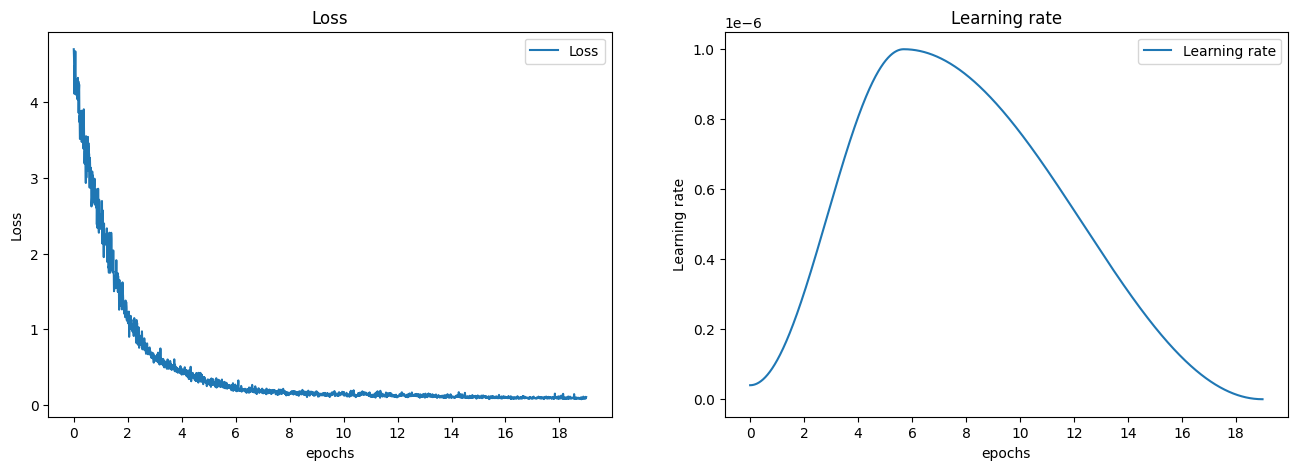

In [ ]:
plotting(history)